In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import ptitprince as pt
import seaborn as sns
import time

from itertools import combinations
from math import log
from scipy.stats import linregress, pearsonr, skew, spearmanr, zscore
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict, cross_validate, KFold, ShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In /Users/amy/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/amy/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/amy/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/amy/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/amy/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-d

### Load data

In [2]:
#data files:
data_path = "/Users/amy/Desktop/coax/group/n_324/"
anat_vol_file = "PIP_n324_Freesurfer_aseg.csv"
anat_SA_file = "PIP_n324_Freesurfer_aparc2009_SA.csv"
anat_thickness_file = "PIP_n324_Freesurfer_aparc2009_thickness.csv"
rs_FC_file = "PIP_n324_rs-FC_FD_residuals.csv"
covariates_file = "PIP_n331_Framingham.csv"
data_file_names = [rs_FC_file, anat_SA_file, anat_thickness_file, anat_vol_file, covariates_file]
demographics_file = "/Users/amy/Desktop/coax/group/n_324/PIP_n324_demographics_modified.csv"
subj_list = "/Users/amy/Desktop/coax/group/n_324/subj_list_n324.csv"

In [3]:
subject_list = pd.read_csv(subj_list, header=None)
str_subject_list = subject_list.astype(str)
n_subj = subject_list[0].count()

In [4]:
def extract_outcome_measure(n_subj, subject_list, outcome_file, ID_column_name, outcome_column_name):

    subjects = subject_list.values.reshape(n_subj,)
    tmp_df = pd.read_csv(outcome_file, usecols=[ID_column_name, outcome_column_name])
    y_tmp = tmp_df.loc[tmp_df[ID_column_name].isin(subjects)]
    y = y_tmp[outcome_column_name].values
    print(outcome_column_name + " loaded")

    return y, y_tmp #df coming back with labels

In [5]:
#extract response variable - IMT
outcome_column_name = "mavgimt"
ID_column_name = "ID"
y, y_df = extract_outcome_measure(n_subj, str_subject_list, demographics_file, ID_column_name, outcome_column_name)

mavgimt loaded


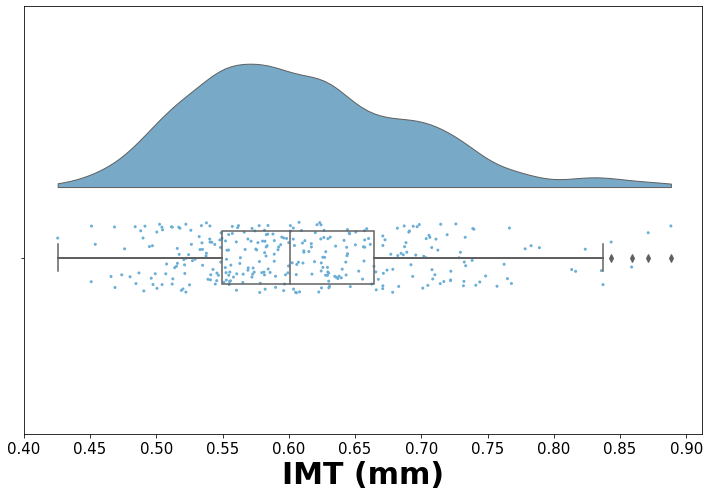

In [6]:
xticks = np.arange(0.4,0.95,0.05)

fig, ax = plt.subplots(figsize=(10,7))

ax = pt.RainCloud(data=y, orient="h", palette='Blues') #BuGn
#ax.set_xlabel("IMT", fontsize='x-large')
ax.set_xlabel(r'IMT (mm)', size=30, weight = 'bold')
ax.yaxis.set_ticklabels([])
plt.xticks(np.round(xticks,2))
#ax.xaxis.set_ticklabels(np.round(xticks,2))
ax.tick_params(axis='x', labelsize=15)
plt.tight_layout()
plt.savefig('/Users/amy/Desktop/coax/IMT_raincloud_111621.png', dpi=600)

In [7]:
def load_combined_data(data_path, filename):

    if 'rs-FC' in filename:
        X_df = pd.read_csv(data_path + filename, header=None)
    else:
        X_df_temp = pd.read_csv(data_path + filename) #header=None
        X_df = X_df_temp.drop(X_df_temp.columns[0], axis=1)
    
    X = X_df.values
    print(filename + " loaded")

    return X

In [8]:
n_sources = 5
n_folds = 5
n_test_set = int(n_subj/n_folds)
n_train_set = n_subj - n_test_set
RANDOM_STATE = 2

In [9]:
rs_FC_data = load_combined_data(data_path, rs_FC_file)
anat_SA_data = load_combined_data(data_path, anat_SA_file)
anat_thickness_data = load_combined_data(data_path, anat_thickness_file)
anat_vol_data = load_combined_data(data_path, anat_vol_file)
data_files = [rs_FC_data, anat_SA_data, anat_thickness_data, anat_vol_data]

PIP_n324_rs-FC_FD_residuals.csv loaded
PIP_n324_Freesurfer_aparc2009_SA.csv loaded
PIP_n324_Freesurfer_aparc2009_thickness.csv loaded
PIP_n324_Freesurfer_aseg.csv loaded


### Functions

In [19]:
def calculate_bic(y, y_hat, n, k):
    
    #calculates BIC (Bayesian Information Criterion)
    
    residuals = y - y_hat
    rss = np.sum(residuals**2)
    #print("rss:", rss, ", n:", n, ", k:", k)
    bic = (n * log(rss/n)) + (k * log(n)) #gaussian special case formula
    
    return bic

In [20]:
def evaluate_model(y_train, y_test, y_predicted_test, num_params, intercept):
    
    #checks for skew and then uses the appropriate evaluation metric depending on presence of skew
    skewness = skew(y_train) #perform skew test on same dataset as cv, so that same overall correlation test run
    skewed = False
    
    if (skewness < 2) and (skewness > -2):
        r,p = pearsonr(y_test, y_predicted_test)
    else: #skewed
        skewed = True
        r,p = spearmanr(y_test, y_predicted_test)
    r2 = r2_score(y_test, y_predicted_test)
    
    #calculate BIC for full model
    bic_full = calculate_bic(y_test, y_predicted_test, n_test_set, num_params)
    #print("Full model bic:", bic_full )
    #calculate BIC for intercept model
    bic_intercept = calculate_bic(y_test, intercept, n_test_set, 1) #is k=1 correct?
    #print("Intercept model bic:", bic_intercept)
    #calculate Bayes factor:
    bf = bic_full/bic_intercept
    #print("Bayes Factor:", bf)

    return r, r2, bf, bic_full

In [21]:
def cross_validation(model, n_folds, X_train, y_train):

    #print("cross_validation")
    kfold = KFold(n_splits=n_folds, random_state=RANDOM_STATE, shuffle=True)
    y_predicted_cv = cross_val_predict(model, X_train, y_train, cv=kfold, verbose=0) 

    cv_scores = cross_validate(model, X_train, y_train, cv=kfold, scoring=('r2', 'neg_mean_absolute_error'), return_train_score=True)
    #print("cv_scores:", cv_scores)
    train_r2_mean = cv_scores['train_r2'].mean()
    test_r2_mean = cv_scores['test_r2'].mean()
    train_mae_mean = cv_scores['train_neg_mean_absolute_error'].mean()
    test_mae_mean = cv_scores['test_neg_mean_absolute_error'].mean()
    cv_means = {'train_r2_mean': train_r2_mean,
                'test_r2_mean': test_r2_mean,
                'train_mae_mean': train_mae_mean,
                'test_mae_mean': test_mae_mean}
    #print("cv_means:", cv_means)
    
    r2_train_set = r2_score(y_train, y_predicted_cv) #this is comparing y observed and y predicted for the train set?
    #print("r2_train_set:", r2_train_set)
    
    return cv_means, y_predicted_cv, kfold, r2_train_set

In [22]:
def run_split_prediction(X_train, X_test, y_train, y_test, n_folds, source_C):

    # set up pipeline
    var_thr = VarianceThreshold() #removed in later versions
    normalize = StandardScaler()
    svr = SVR(kernel='linear', C=source_C)
    pipeline_list = [('var_thr', var_thr), ('normalize', normalize), ('svr', svr)]
    pipe = Pipeline(pipeline_list)
    pipe.fit(X_train, y_train)
    #y_predicted_train = pipe.predict(X_train) #should I be using this?
    y_predicted_test = pipe.predict(X_test) 
    
    svr_coef = pipe['svr'].coef_
    num_params = (pipe['svr'].coef_).size + 1
    svr_intercept = pipe['svr'].intercept_
    
    # run cross-validation
    step1_cv_means, y_predicted_cv, k_fold, r2_train_set = cross_validation(pipe, n_folds, X_train, y_train)

    return step1_cv_means, y_predicted_cv, y_predicted_test, k_fold, r2_train_set, svr_coef, num_params, svr_intercept

In [23]:
def tune_and_train_rf(X_train, y_train, n_folds):

    #Uses oob estimates to find optimal max_depth between None + 0...20
    #Refits with best max_depth
    oob_score = []
    cv_list = [None] + list(range(1, 20))
    for md in cv_list:
        rf = RandomForestRegressor(n_estimators=100, max_depth=md, oob_score=True, random_state=RANDOM_STATE, n_jobs=-1)
        rf.fit(X_train, y_train)
        oob_score.append(rf.oob_score_) #r2
    best_max_depth = cv_list[np.argmax(oob_score)]
    rf_opt = RandomForestRegressor(n_estimators=100, max_depth=best_max_depth, oob_score=True, random_state=RANDOM_STATE, n_jobs=-1)

    # CV
    step2_cv_means, y_predicted_cv2, k_fold, r2_train = cross_validation(rf_opt, n_folds, X_train, y_train)
    
    # refit
    rf_opt.fit(X_train, y_train)
    return rf_opt, step2_cv_means, y_predicted_cv2

In [24]:
def second_level_RF(stacked_predictions_train, stacked_predictions_test, y_train, y_test, n_folds):
    
    rf, step2_cv_means, y_predicted_cv2 = tune_and_train_rf(stacked_predictions_train, y_train, n_folds)
    y_predicted_test2 = rf.predict(stacked_predictions_test)
    
    #rf_num_params = rf.n_features_ #is this correct?
    #rf_importance = rf.feature_importances_
    #max_importance_index = np.argmax(rf_importance)
    #rf_intercept = stacked_predictions_test[:, max_importance_index] #using this as the equivalent of the svr intercept for rf (different for each subject)
    #print("X:", y_predicted_cv2.shape, y_train.shape)
    #print("y:", y_predicted_test2.shape, y_test.shape)
    regression = LinearRegression()
    regression.fit(y_predicted_cv2.reshape(-1,1), y_train.reshape(-1,1)) # is this correct?
    regression.predict(y_predicted_test2.reshape(-1,1)) # is this correct?
    reg_num_params = (regression.coef_).size
    reg_intercept = regression.intercept_
    #print("num params:", reg_num_params, "intercept:", reg_intercept)
    
    r_test2, r2_test2, bf_test2, bic_test2 = evaluate_model(y_train, y_test, y_predicted_test2, reg_num_params, reg_intercept)
    
    return r_test2, r2_test2, bf_test2, bic_test2, y_predicted_cv2, y_predicted_test2 

### First level - SVR

In [16]:
#FIRST LEVEL
n_sources = 4
data_files = [rs_FC_data, anat_SA_data, anat_thickness_data, anat_vol_data]
data_file_names = [rs_FC_file, anat_SA_file, anat_thickness_file, anat_vol_file]

start_time = time.time()
print("Starting first level...")
stacked_predictions_train = np.zeros(shape=(n_train_set, n_sources)) 
stacked_predictions_test = np.zeros(shape=(n_test_set, n_sources))
source_index = 0
source_C = 10 ** -3

stacked_step1_r2_test = np.zeros(shape=(1,n_sources))
svr_coefs = []

for source_name, source in zip(data_file_names, data_files):
    print("source", source_index + 1, ": ", source_name)
    if 'aseg' in source_name:
        source_C = 1
    X = source
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test_set, random_state=RANDOM_STATE)
    step1_cv_means, y_predicted_cv, y_predicted_test, k_fold, step1_r2_train_set, svr_coef, svr_num_params, svr_intercept = run_split_prediction(X_train, X_test, y_train, y_test, n_folds, source_C)

    svr_coefs.append(svr_coef)
    #compute correlation coefficient and coefficient of determination on test set:
    step1_r_test_set, step1_r2_test_set, step1_bf, step1_bic = evaluate_model(y_train, y_test, y_predicted_test, svr_num_params, svr_intercept)
    print("test set r:", step1_r_test_set)
    print("test set coefficient of determination (r2):", step1_r2_test_set)
    #prediction stacking
    stacked_predictions_train[:,source_index] = y_predicted_cv 
    stacked_predictions_test[:,source_index] = y_predicted_test
    stacked_step1_r2_test[0,source_index] = step1_r2_test_set
    source_index += 1
    
print("First level complete")
end_time = time.time()
elapsed_time = end_time - start_time
print("time elapsed:", str(datetime.timedelta(seconds=elapsed_time)))

Starting first level...
source 1 :  PIP_n324_rs-FC_FD_residuals.csv
test set r: 0.0847512889678434
test set coefficient of determination (r2): -0.026782505875597495
source 2 :  PIP_n324_Freesurfer_aparc2009_SA.csv
test set r: 0.23294174693615213
test set coefficient of determination (r2): 0.033904107756368984
source 3 :  PIP_n324_Freesurfer_aparc2009_thickness.csv
test set r: 0.1305792291829717
test set coefficient of determination (r2): -0.033182755088528415
source 4 :  PIP_n324_Freesurfer_aseg.csv
test set r: 0.024373012588614587
test set coefficient of determination (r2): -0.25408402863174495
First level complete
time elapsed: 0:00:13.892756


### Observed vs. predicted plots

Text(0.5, 0.98, 'Observed vs. predicted intima media thickness')

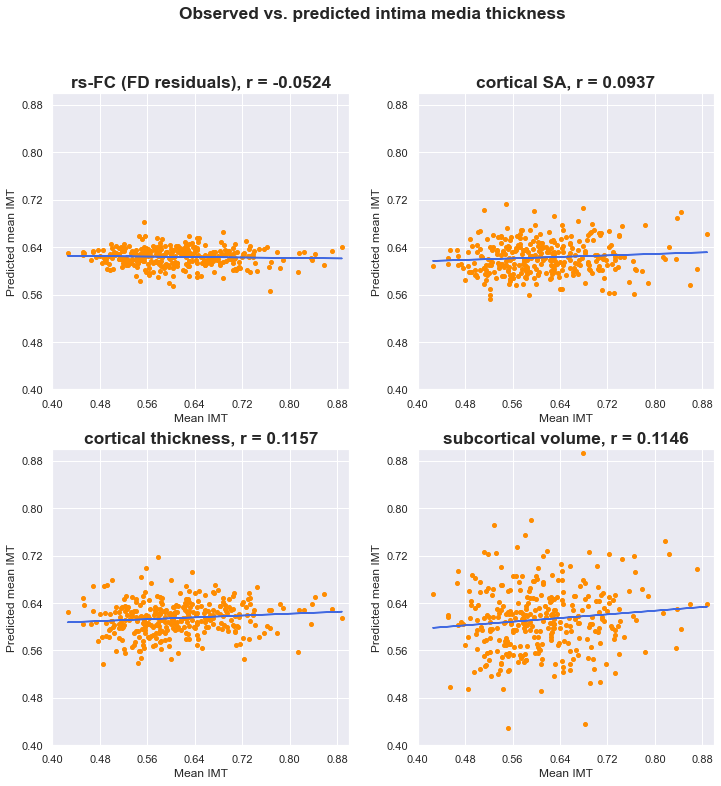

In [17]:
sns.set()

titles = ['rs-FC (FD residuals)','cortical SA','cortical thickness','subcortical volume']

y_observed = np.concatenate((y_train, y_test))

fig1, axes1 = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
for i, ax in enumerate(fig1.axes):

    
    predicted = np.concatenate((stacked_predictions_train[:,i], stacked_predictions_test[:,i]))
    #calculate line of best fit
    slope, line_intercept, r_value, p_value, std_err = linregress(y_observed, predicted)
    line = slope*y_observed + line_intercept

    ax.scatter(y_observed, predicted, color='darkorange', s=16)
    ax.plot(y_observed, line, color='royalblue')

    ax.set_title(titles[i] + ", r = " + str(round(r_value,4)), fontsize='x-large', fontweight='bold')
    ax.set_xlabel('Mean IMT')
    ax.set_ylabel('Predicted mean IMT')
    ax.set_xlim((0.4,0.9))
    ax.set_ylim((0.4,0.9))
    ax.set_xticks(np.arange(0.4,0.9,0.08))
    ax.set_yticks(np.arange(0.4,0.9,0.08))
    ax.set_aspect('equal')
    
fig1.suptitle('Observed vs. predicted intima media thickness',fontsize='x-large', fontweight='bold')



### Second level - RF

In [17]:
#SECOND LEVEL
start_time = time.time()
print("Starting second level...")
r_test2, r2_test2, bf_test2, bic_test2, y_predicted_cv2, y_predicted_test2 = second_level_RF(stacked_predictions_train, 
                                                                                             stacked_predictions_test, 
                                                                                             y_train, y_test, n_folds)
print("test set r:", r_test2)
print("test set coefficient of determination (r2):", r2_test2)
print("Second level complete")
end_time = time.time()
elapsed_time = end_time - start_time
print("time elapsed:", str(datetime.timedelta(seconds=elapsed_time)))

Starting second level...
test set r: 0.1549905069070182
test set coefficient of determination (r2): 0.0214295745847074
Second level complete
time elapsed: 0:00:12.998022


### Channel combinations

In [18]:
n_channels = len(data_files)
channel_subsets = []
    
for k in np.arange(2, n_channels +1):    
    channel_subsets += list(combinations(np.arange(n_channels), k))

num_comb = len(channel_subsets)

In [19]:
def calculate_stacking_bonus(stacked_test_combination, y_predicted_test2, y_test, r2_test2, stacked_r2s):
    
    n_sources_comb = stacked_test_combination.shape[1]
    #print(n_sources_comb)
    
    single_channel_test = np.square(stacked_test_combination.transpose() - y_test.reshape(1,y_test.size))
    single_channel_total = (np.sum(single_channel_test))/n_sources_comb

    group_bonus_test = np.square(y_test - y_predicted_test2)
    sum_group_bonus = np.sum(group_bonus_test)

    stacking_bonus = single_channel_total - sum_group_bonus
    #alternate r2 method of calculating stacking bonus: 
    stacking_bonus2 = r2_test2 - (np.sum(stacked_r2s)/n_sources_comb) #average of single channel r2s
    stacking_bonus3 = r2_test2 - np.amax(stacked_r2s) #best single channel r2
    
    return (stacking_bonus, stacking_bonus2, stacking_bonus3)

In [21]:
#############################################
#Haven't run (or changed for saving bic) - don't need stacking bonuses (?)

#SECOND LEVEL
start_time = time.time()
print("Starting second level combinations...")

comb_r = np.zeros(num_comb)
comb_r2 = np.zeros(num_comb)
comb_bf = np.zeros(num_comb)
comb_stacking_bonus = np.zeros(num_comb)
comb_stacking_bonus2 = np.zeros(num_comb)
comb_stacking_bonus3 = np.zeros(num_comb)
best_r2 = -np.inf
best_subset = None
best_bonus = 0
str_subset = []

for comb_i, subset in enumerate(channel_subsets):
    str_subset.append(str(subset))
    stacked_train_combination = stacked_predictions_train[:,list(subset)]
    stacked_test_combination = stacked_predictions_test[:,list(subset)]
    stacked_r2s = stacked_step1_r2_test[:,list(subset)]
    #print(subset, stacked_r2s)
    comb_r[comb_i], comb_r2[comb_i], comb_bf[comb_i], y_predicted_cv2, y_predicted_test2 = second_level_RF(stacked_train_combination, stacked_test_combination, y_train, y_test, n_folds)
    comb_stacking_bonus[comb_i], comb_stacking_bonus2[comb_i], comb_stacking_bonus3[comb_i] = calculate_stacking_bonus(stacked_test_combination, y_predicted_test2, y_test, comb_r2[comb_i], stacked_r2s)
    if comb_r2[comb_i] > best_r2:
        print("new best r2 = ", comb_r2[comb_i], "for subset", subset)
        print("stacking bonus =", comb_stacking_bonus[comb_i])
        best_r2 = comb_r2[comb_i]
        best_subset = subset
        best_bonus = comb_stacking_bonus[comb_i]

print("combination r's:", comb_r)
print("combination coefficient of determinations (r2):", comb_r2)
print("combination bf's:", comb_bf)
print("combination stacking bonuses:")
print(comb_stacking_bonus)
print("combination stacking bonuses 2: percentage r2 average single channel")
print(comb_stacking_bonus2)
print("combination stacking bonuses 3: percentage r2 single best channel)")
print(comb_stacking_bonus3)
print("best subset:", best_subset, "with r2 =", best_r2)

print("Second level combinations complete")
end_time = time.time()
elapsed_time = end_time - start_time
print("time elapsed:", str(datetime.timedelta(seconds=elapsed_time)))

Starting second level combinations...
new best r2 =  -0.006652118200682455 for subset (0, 1)
stacking bonus = -0.005208005438077423
new best r2 =  0.10168804725979241 for subset (1, 2)
stacking bonus = 0.051671171730518606
combination r's: [ 0.07394632  0.05485534 -0.16805212  0.32771723  0.12048296  0.11918914
  0.22547228 -0.03035909 -0.02862694  0.21324098  0.15499051]
combination coefficient of determinations (r2): [-0.00665212 -0.01179659 -0.04738314  0.10168805  0.0094801   0.01276697
  0.05077239 -0.01498876 -0.03653577  0.03908158  0.02142957]
combination bf's: [1.43061467 2.47206375 1.69055595 1.61563695 1.03722434 1.86222768
 1.59607921 1.27808262 2.79657976 1.46572789 1.82902522]
combination stacking bonuses:
[-0.00520801  0.00927384  0.04745025  0.05167117  0.0609739   0.07975525
  0.03032092  0.0343355   0.03475125  0.06299621  0.04664237]
combination stacking bonuses 2: percentage r2 average single channel
[-0.01021292  0.01818604  0.09305013  0.10132737  0.11957006  0.15

In [10]:
#extract framingham indices - HCHD, HeartAge, TotalPoints
ID_column_name = "ePrime.id"

TotalPoints_column_name = "TotalPoints"
TotalPoints_tempX, TotalPoints_df_temp = extract_outcome_measure(n_subj, str_subject_list, data_path+covariates_file, 
                                                      ID_column_name, TotalPoints_column_name)

HCHD_column_name = "HCHD"
HCHD_tempX, HCHD_df_temp = extract_outcome_measure(n_subj, str_subject_list, data_path+covariates_file, 
                                        ID_column_name, HCHD_column_name)

HeartAge_column_name = "HeartAge"
HeartAge_tempX, HeartAge_df_temp = extract_outcome_measure(n_subj, str_subject_list, data_path+covariates_file, 
                                                ID_column_name, HeartAge_column_name)

TotalPoints loaded
HCHD loaded
HeartAge loaded


In [11]:
#sort df framingham data by ID
TotalPoints_df = TotalPoints_df_temp.sort_values(by=[ID_column_name])
HCHD_df = HCHD_df_temp.sort_values(by=[ID_column_name])
HeartAge_df = HeartAge_df_temp.sort_values(by=[ID_column_name])

#get sorted numpy data from df
TotalPoints_temp = TotalPoints_df[TotalPoints_column_name].values
HCHD_temp = HCHD_df[HCHD_column_name].values
HeartAge_temp = HeartAge_df[HeartAge_column_name].values

In [12]:
i_nan = [57,61,251,273,283,284]
np.put(TotalPoints_temp, i_nan, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
TotalPoints = TotalPoints_temp.astype(np.float)

In [13]:
#create covariate channel
cov_data = TotalPoints.reshape(-1, 1)
cov_data.shape

(324, 1)

In [19]:
data_files = [rs_FC_data, anat_SA_data, anat_thickness_data, anat_vol_data, cov_data]

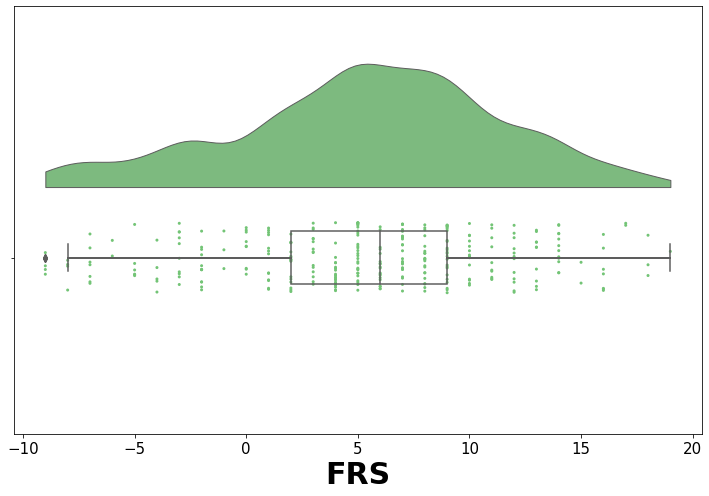

In [26]:
#import matplotlib
#matplotlib.rc_file_defaults()

fig, ax = plt.subplots(figsize=(10,7))
ax = pt.RainCloud(data=cov_data, orient="h", palette='Greens')
#ax.set_xlabel("FRS", fontsize='x-large')
ax.set_xlabel(r'FRS', size=30, weight = 'bold')
ax.tick_params(axis='x', labelsize=15)
ax.yaxis.set_ticklabels([])
plt.tight_layout()
plt.savefig('/Users/amy/Desktop/coax/FRS_raincloud_092121.png', dpi=600)




### monte carlo



### final set of models

In [20]:
#with cv
def run_cov_regression(X_train, X_test, y_train, y_test):

    # set up pipeline
    var_thr = VarianceThreshold() 
    normalize = StandardScaler()
    lr = LinearRegression()
    pipeline_list = [('var_thr', var_thr), ('normalize', normalize), ('lr', lr)]
    pipe = Pipeline(pipeline_list)
    pipe.fit(X_train, y_train)
    y_predicted_test = pipe.predict(X_test)
    
    lr_coef = pipe['lr'].coef_
    lr_intercept = pipe['lr'].intercept_
    
    # run cross-validation
    step1_cv_means, y_predicted_cv, k_fold, r2_train_set = cross_validation(pipe, n_folds, X_train, y_train)

    return step1_cv_means, y_predicted_cv, y_predicted_test, k_fold, lr_coef, lr_intercept

#### 5 channel cv model

In [15]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
cov_data_imputed = imputer.fit_transform(cov_data)

In [35]:
#############################################
#Haven't run (or changed for saving bic) - don't need full model without mc (?)


#FIRST LEVEL
n_sources = 5
data_files = [rs_FC_data, anat_SA_data, anat_thickness_data, anat_vol_data, cov_data_imputed]
data_file_names = [rs_FC_file, anat_SA_file, anat_thickness_file, anat_vol_file, covariates_file]

start_time = time.time()
print("Starting first level...")
stacked_predictions_train = np.zeros(shape=(n_train_set, n_sources)) 
stacked_predictions_test = np.zeros(shape=(n_test_set, n_sources))
source_index = 0
source_C = 10 ** -3

stacked_step1_r2_test = np.zeros(shape=(1,n_sources))
svr_coefs = []

for source_name, source in zip(data_file_names, data_files):
    print("source", source_index + 1, ": ", source_name)
    if 'aseg' in source_name:
        source_C = 1
    X = source
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test_set, random_state=RANDOM_STATE)
    if 'Framingham' in source_name:
        #linear regression
        step1_cv_means, y_predicted_cv, y_predicted_test, k_fold, lr_coef, lr_intercept = run_cov_regression(X_train, X_test, 
                                                                                               y_train, y_test)
        #dummy values to exclude lr
        svr_num_params = -1
        svr_intercept = -99
        #y_predicted_cv, y_predicted_test, step1_r_test_set, step1_r2_test_set = run_cov_regression(X_train, X_test, 
        #                                                                                           y_train, y_test)
    else:
        step1_cv_means, y_predicted_cv, y_predicted_test, k_fold, step1_r2_train_set, svr_coef, svr_num_params, svr_intercept = run_split_prediction(X_train, X_test, y_train, y_test, n_folds, source_C)
        svr_coefs.append(svr_coef)
    
    #compute correlation coefficient and coefficient of determination on test set:
    step1_r_test_set, step1_r2_test_set, step1_bf = evaluate_model(y_train, y_test, y_predicted_test, 
                                                                       svr_num_params, svr_intercept)
    
    print("step1_cv_means:", step1_cv_means)
    print("test set r:", step1_r_test_set)
    print("test set coefficient of determination (r2):", step1_r2_test_set)
    #prediction stacking
    stacked_predictions_train[:,source_index] = y_predicted_cv 
    stacked_predictions_test[:,source_index] = y_predicted_test
    stacked_step1_r2_test[0,source_index] = step1_r2_test_set
    source_index += 1
    
print("First level complete")
end_time = time.time()
elapsed_time = end_time - start_time
print("time elapsed:", str(datetime.timedelta(seconds=elapsed_time)))

Starting first level...
source 1 :  PIP_n324_rs-FC_FD_residuals.csv
step1_cv_means: {'train_r2_mean': 0.30305060252583726, 'test_r2_mean': -0.13216726534873105, 'train_mae_mean': -0.05952076770265106, 'test_mae_mean': -0.06995593352359071}
test set r: 0.0847512889678434
test set coefficient of determination (r2): -0.026782505875597495
source 2 :  PIP_n324_Freesurfer_aparc2009_SA.csv
step1_cv_means: {'train_r2_mean': 0.251911258783165, 'test_r2_mean': -0.13651692195840032, 'train_mae_mean': -0.061098407063585325, 'test_mae_mean': -0.06997185917652607}
test set r: 0.23294174693615213
test set coefficient of determination (r2): 0.033904107756368984
source 3 :  PIP_n324_Freesurfer_aparc2009_thickness.csv
step1_cv_means: {'train_r2_mean': 0.27736118378053315, 'test_r2_mean': -0.07444134041145248, 'train_mae_mean': -0.05902670417561353, 'test_mae_mean': -0.06514147004861343}
test set r: 0.1305792291829717
test set coefficient of determination (r2): -0.033182755088528415
source 4 :  PIP_n324_

In [36]:
#############################################
#Haven't run (or changed for saving bic) - don't need full model without mc (?)

#SECOND LEVEL
start_time = time.time()
print("Starting second level...")
r_test2, r2_test2, bf_test2, y_predicted_cv2, y_predicted_test2 = second_level_RF(stacked_predictions_train, 
                                                                                  stacked_predictions_test, 
                                                                                  y_train, y_test, n_folds)
print("test set r:", r_test2)
print("test set coefficient of determination (r2):", r2_test2)
print("Second level complete")
end_time = time.time()
elapsed_time = end_time - start_time
print("time elapsed:", str(datetime.timedelta(seconds=elapsed_time)))

Starting second level...
test set r: 0.33891255755416694
test set coefficient of determination (r2): 0.11416271267990263
Second level complete
time elapsed: 0:00:11.116975


#### channel combinations

In [22]:
data_files = [rs_FC_data, anat_SA_data, anat_thickness_data, anat_vol_data, cov_data_imputed]
data_file_names = [rs_FC_file, anat_SA_file, anat_thickness_file, anat_vol_file, covariates_file]

n_channels = len(data_files)
channel_subsets = []
    
for k in np.arange(2, n_channels +1):    
    channel_subsets += list(combinations(np.arange(n_channels), k))

num_comb = len(channel_subsets)

In [23]:
str_subset = []

for comb_i, subset in enumerate(channel_subsets):
    str_subset.append(str(subset))
    
str_subset

['(0, 1)',
 '(0, 2)',
 '(0, 3)',
 '(0, 4)',
 '(1, 2)',
 '(1, 3)',
 '(1, 4)',
 '(2, 3)',
 '(2, 4)',
 '(3, 4)',
 '(0, 1, 2)',
 '(0, 1, 3)',
 '(0, 1, 4)',
 '(0, 2, 3)',
 '(0, 2, 4)',
 '(0, 3, 4)',
 '(1, 2, 3)',
 '(1, 2, 4)',
 '(1, 3, 4)',
 '(2, 3, 4)',
 '(0, 1, 2, 3)',
 '(0, 1, 2, 4)',
 '(0, 1, 3, 4)',
 '(0, 2, 3, 4)',
 '(1, 2, 3, 4)',
 '(0, 1, 2, 3, 4)']

In [24]:
channel_subsets_v2 = []
    
for k in np.arange(2, n_channels +1):    
    channel_subsets_v2 += list(combinations(np.arange(1,n_channels+1), k))
    
channel_subsets_v2

[(1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 4),
 (2, 5),
 (3, 4),
 (3, 5),
 (4, 5),
 (1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 3, 4),
 (1, 3, 5),
 (1, 4, 5),
 (2, 3, 4),
 (2, 3, 5),
 (2, 4, 5),
 (3, 4, 5),
 (1, 2, 3, 4),
 (1, 2, 3, 5),
 (1, 2, 4, 5),
 (1, 3, 4, 5),
 (2, 3, 4, 5),
 (1, 2, 3, 4, 5)]

In [25]:
str_subset_v2 = []

for i, subset in enumerate(channel_subsets_v2):
    str_subset_v2.append(str(subset))
    
str_subset_v2

['(1, 2)',
 '(1, 3)',
 '(1, 4)',
 '(1, 5)',
 '(2, 3)',
 '(2, 4)',
 '(2, 5)',
 '(3, 4)',
 '(3, 5)',
 '(4, 5)',
 '(1, 2, 3)',
 '(1, 2, 4)',
 '(1, 2, 5)',
 '(1, 3, 4)',
 '(1, 3, 5)',
 '(1, 4, 5)',
 '(2, 3, 4)',
 '(2, 3, 5)',
 '(2, 4, 5)',
 '(3, 4, 5)',
 '(1, 2, 3, 4)',
 '(1, 2, 3, 5)',
 '(1, 2, 4, 5)',
 '(1, 3, 4, 5)',
 '(2, 3, 4, 5)',
 '(1, 2, 3, 4, 5)']

In [38]:
#############################################
#Haven't run (or changed for saving bic) - don't need channel combination models without mc (?)

#SECOND LEVEL
start_time = time.time()
print("Starting second level combinations...")

comb_r = np.zeros(num_comb)
comb_r2 = np.zeros(num_comb)
comb_bf = np.zeros(num_comb)
comb_stacking_bonus = np.zeros(num_comb)
comb_stacking_bonus2 = np.zeros(num_comb)
comb_stacking_bonus3 = np.zeros(num_comb)
best_r2 = -np.inf
best_subset = None
best_bonus = 0
str_subset = []

for comb_i, subset in enumerate(channel_subsets):
    str_subset.append(str(subset))
    stacked_train_combination = stacked_predictions_train[:,list(subset)]
    stacked_test_combination = stacked_predictions_test[:,list(subset)]
    stacked_r2s = stacked_step1_r2_test[:,list(subset)]
    #print(subset, stacked_r2s)
    comb_r[comb_i], comb_r2[comb_i], comb_bf[comb_i], y_predicted_cv2, y_predicted_test2 = second_level_RF(stacked_train_combination, stacked_test_combination, y_train, y_test, n_folds)
    comb_stacking_bonus[comb_i], comb_stacking_bonus2[comb_i], comb_stacking_bonus3[comb_i] = calculate_stacking_bonus(stacked_test_combination, y_predicted_test2, y_test, comb_r2[comb_i], stacked_r2s)
    if comb_r2[comb_i] > best_r2:
        print("new best r2 = ", comb_r2[comb_i], "for subset", subset)
        print("stacking bonus =", comb_stacking_bonus[comb_i])
        best_r2 = comb_r2[comb_i]
        best_subset = subset
        best_bonus = comb_stacking_bonus[comb_i]

print("combination r's:", comb_r)
print("combination coefficient of determinations (r2):", comb_r2)
print("combination bf's:", comb_bf)
print("combination stacking bonuses:")
print(comb_stacking_bonus)
print("combination stacking bonuses 2: percentage r2 average single channel")
print(comb_stacking_bonus2)
print("combination stacking bonuses 3: percentage r2 single best channel)")
print(comb_stacking_bonus3)
print("best subset:", best_subset, "with r2 =", best_r2)

print("Second level combinations complete")
end_time = time.time()
elapsed_time = end_time - start_time
print("time elapsed:", str(datetime.timedelta(seconds=elapsed_time)))

Starting second level combinations...
new best r2 =  -0.006652118200682455 for subset (0, 1)
stacking bonus = -0.005208005438077423
new best r2 =  0.11273668363848555 for subset (0, 4)
stacking bonus = 0.021910514233419387
new best r2 =  0.16805354857063293 for subset (1, 4)
stacking bonus = 0.034645602476125636
new best r2 =  0.21335950615877308 for subset (1, 2, 4)
stacking bonus = 0.08040685931288022
combination r's: [ 0.07394632  0.05485534 -0.16805212  0.33613595  0.32771723  0.12048296
  0.41026624  0.11918914  0.34045966  0.34375806  0.22547228 -0.03035909
  0.331093   -0.02862694  0.32712787  0.28890219  0.21324098  0.46507638
  0.3844439   0.34171268  0.15499051  0.36924875  0.33234024  0.29626729
  0.38447672  0.33891256]
combination coefficient of determinations (r2): [-0.00665212 -0.01179659 -0.04738314  0.11273668  0.10168805  0.0094801
  0.16805355  0.01276697  0.11537699  0.11674386  0.05077239 -0.01498876
  0.1075331  -0.03653577  0.10493493  0.08006015  0.03908158  0.2

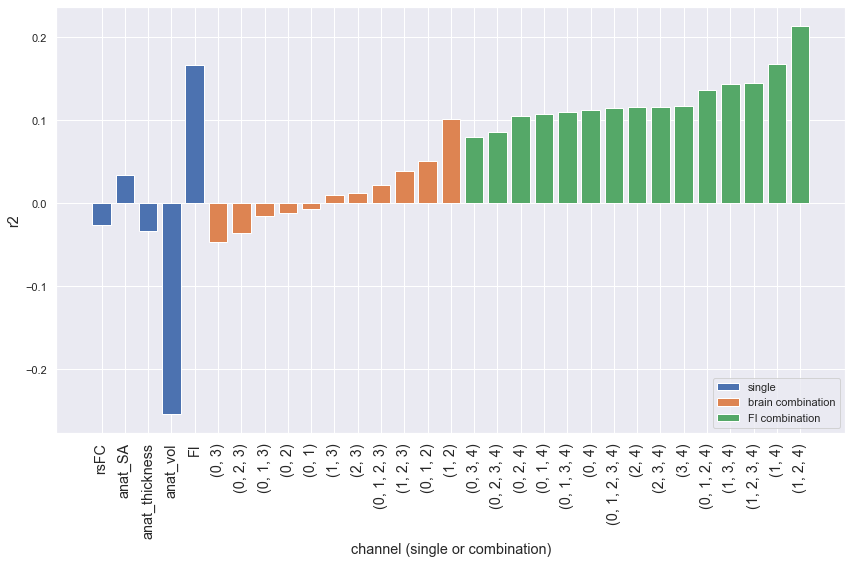

In [132]:
#replot sorted and FI separated

single_channels = ['rsFC', 'anat_SA', 'anat_thickness', 'anat_vol', 'FI']
data_step1 = stacked_step1_r2_test
data_brain = r2_brain
data_FI = r2_FI

zipped_brain = zip(data_brain, str_brain)
zipped_sorted_brain = sorted(zipped_brain)
tuples_brain = zip(*zipped_sorted_brain)
sorted_r2s_brain, sorted_strs_brain = [ list(tuple) for tuple in  tuples_brain ]

zipped_FI = zip(data_FI, str_FI)
zipped_sorted_FI = sorted(zipped_FI)
tuples_FI = zip(*zipped_sorted_FI)
sorted_r2s_FI, sorted_strs_FI = [ list(tuple) for tuple in  tuples_FI ]

labels = single_channels + sorted_strs_brain + sorted_strs_FI
y_labels = 'r2'
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
axes.bar(single_channels, data_step1[0,:], label='single')
axes.bar(sorted_strs_brain, sorted_r2s_brain, label='brain combination')
axes.bar(sorted_strs_FI, sorted_r2s_FI, label='FI combination')
axes.set_xticklabels(labels, rotation='vertical', fontsize='large')
axes.set_xlabel("channel (single or combination)", fontsize='large')
axes.set_ylabel(y_labels, fontsize='large')
axes.legend(loc='lower right')

plt.tight_layout()
plt.savefig("/Users/amy/Desktop/coax/channel_combinations.png", dpi=600)

In [181]:
zipped_sorted

[(-0.04738313728653276, '(0, 3)'),
 (-0.036535765792470754, '(0, 2, 3)'),
 (-0.014988764849254377, '(0, 1, 3)'),
 (-0.011796591730062644, '(0, 2)'),
 (-0.006652118200682455, '(0, 1)'),
 (0.0094800977385332, '(1, 3)'),
 (0.01276696732987248, '(2, 3)'),
 (0.02142957458470751, '(0, 1, 2, 3)'),
 (0.0390815804729685, '(1, 2, 3)'),
 (0.050772391176744924, '(0, 1, 2)'),
 (0.08006015240322717, '(0, 3, 4)'),
 (0.08526484986031124, '(0, 2, 3, 4)'),
 (0.10168804725979241, '(1, 2)'),
 (0.10493493409989507, '(0, 2, 4)'),
 (0.1075331001674753, '(0, 1, 4)'),
 (0.10957320144103033, '(0, 1, 3, 4)'),
 (0.11273668363848555, '(0, 4)'),
 (0.11416271267990263, '(0, 1, 2, 3, 4)'),
 (0.1153769908835498, '(2, 4)'),
 (0.11590896663897243, '(2, 3, 4)'),
 (0.1167438615597498, '(3, 4)'),
 (0.13611695428885795, '(0, 1, 2, 4)'),
 (0.1439343936626455, '(1, 3, 4)'),
 (0.14442856705225904, '(1, 2, 3, 4)'),
 (0.1680535485706326, '(1, 4)'),
 (0.21335950615877297, '(1, 2, 4)')]

In [173]:
zipped = zip(comb_r2, str_subset)
zipped_sorted = sorted(zipped)

tuples = zip(*zipped_sorted)
sorted_r2s, sorted_strs = [ list(tuple) for tuple in  tuples ]

In [175]:
sorted_strs

['(0, 3)',
 '(0, 2, 3)',
 '(0, 1, 3)',
 '(0, 2)',
 '(0, 1)',
 '(1, 3)',
 '(2, 3)',
 '(0, 1, 2, 3)',
 '(1, 2, 3)',
 '(0, 1, 2)',
 '(0, 3, 4)',
 '(0, 2, 3, 4)',
 '(1, 2)',
 '(0, 2, 4)',
 '(0, 1, 4)',
 '(0, 1, 3, 4)',
 '(0, 4)',
 '(0, 1, 2, 3, 4)',
 '(2, 4)',
 '(2, 3, 4)',
 '(3, 4)',
 '(0, 1, 2, 4)',
 '(1, 3, 4)',
 '(1, 2, 3, 4)',
 '(1, 4)',
 '(1, 2, 4)']

#### monte carlo

In [30]:
#100 runs - on channel combinations

n_sources = 5
data_files = [rs_FC_data, anat_SA_data, anat_thickness_data, anat_vol_data, cov_data_imputed]
data_file_names = [rs_FC_file, anat_SA_file, anat_thickness_file, anat_vol_file, covariates_file]

n_splits = 100
rs = ShuffleSplit(n_splits=n_splits, test_size=n_test_set, train_size=n_train_set, random_state=RANDOM_STATE)

mc_y_train = np.zeros(shape=(n_splits,n_train_set))
mc_y_test = np.zeros(shape=(n_splits,n_test_set))

i_split = 0
step1_corrs = np.zeros(shape=(n_splits, n_sources))
step1_r2s = np.zeros(shape=(n_splits, n_sources))
step1_bfs = np.zeros(shape=(n_splits, n_sources))
step1_bics = np.zeros(shape=(n_splits, n_sources))

mc_stacked_predictions_train = np.zeros(shape=(n_splits, n_sources, n_train_set)) 
mc_stacked_predictions_test = np.zeros(shape=(n_splits, n_sources, n_test_set)) 


comb_r = np.zeros(shape=(n_splits,num_comb))
comb_r2 = np.zeros(shape=(n_splits,num_comb))
comb_bf = np.zeros(shape=(n_splits,num_comb))
comb_bic = np.zeros(shape=(n_splits,num_comb))
comb_stacking_bonus = np.zeros(shape=(n_splits,num_comb))
comb_stacking_bonus2 = np.zeros(shape=(n_splits,num_comb))
comb_stacking_bonus3 = np.zeros(shape=(n_splits,num_comb))

comb_y_pred_cv = np.zeros(shape=(n_splits,num_comb,n_train_set))
comb_y_pred_test = np.zeros(shape=(n_splits,num_comb,n_test_set))


for train_index, test_index in rs.split(np.zeros(n_subj)):
    print("Split:", i_split)
    
    #first level
    stacked_predictions_train = np.zeros(shape=(n_train_set, n_sources)) 
    stacked_predictions_test = np.zeros(shape=(n_test_set, n_sources))
    source_index = 0
    source_C = 10 ** -3
    
    y_train, y_test = y[train_index], y[test_index]
    mc_y_train[i_split,:] = y_train
    mc_y_test[i_split,:] = y_test

    for source_name, source in zip(data_file_names, data_files):
        if 'aseg' in source_name:
            source_C = 1
        X_train, X_test = source[train_index], source[test_index]
        
        if 'Framingham' in source_name:
            #linear regression
            step1_cv_means, y_predicted_cv, y_predicted_test, k_fold, lr_coef, lr_intercept = run_cov_regression(X_train, X_test, 
                                                                                                   y_train, y_test)
            #dummy values to exclude lr
            svr_num_params = -1
            svr_intercept = -99
        else:
            step1_cv_means, y_predicted_cv, y_predicted_test, k_fold, step1_r2_train_set, svr_coef, svr_num_params, svr_intercept = run_split_prediction(X_train, X_test, y_train, y_test, n_folds, source_C)
            #svr_coefs.append(svr_coef)
        
        #compute correlation coefficient, coefficient of determination and bayes factor on test set:
        step1_r_test_set, step1_r2_test_set, step1_bf, step1_bic = evaluate_model(y_train, y_test, y_predicted_test, svr_num_params, svr_intercept)
        step1_corrs[i_split,source_index] = step1_r_test_set 
        step1_r2s[i_split,source_index] = step1_r2_test_set
        step1_bfs[i_split,source_index] = step1_bf
        step1_bics[i_split,source_index] = step1_bic
        #prediction stacking
        stacked_predictions_train[:,source_index] = y_predicted_cv
        stacked_predictions_test[:,source_index] = y_predicted_test
        
        source_index += 1
        
    mc_stacked_predictions_train[i_split,:,:] = stacked_predictions_train.T
    mc_stacked_predictions_test[i_split,:,:] = stacked_predictions_test.T
    #second level
    for comb_i, subset in enumerate(channel_subsets):
        #str_subset.append(str(subset))
        print("combination:", comb_i)
        stacked_train_combination = stacked_predictions_train[:,list(subset)]
        stacked_test_combination = stacked_predictions_test[:,list(subset)]
        #stacked_r2s = stacked_step1_r2_test[:,list(subset)]
        stacked_r2s = step1_r2s[i_split,list(subset)]
        #print(subset, stacked_r2s)
        comb_r[i_split,comb_i], comb_r2[i_split,comb_i], comb_bf[i_split,comb_i], comb_bic[i_split,comb_i], y_predicted_cv2, y_predicted_test2 = second_level_RF(stacked_train_combination, stacked_test_combination, y_train, y_test, n_folds)
        comb_stacking_bonus[i_split,comb_i], comb_stacking_bonus2[i_split,comb_i], comb_stacking_bonus3[i_split,comb_i] = calculate_stacking_bonus(stacked_test_combination, y_predicted_test2, y_test, comb_r2[i_split,comb_i], stacked_r2s)
        comb_y_pred_cv[i_split,comb_i,:] = y_predicted_cv2
        comb_y_pred_test[i_split,comb_i,:] = y_predicted_test2

    
    i_split += 1


print(" ")
print(" ")
print("MONTE CARLO:")
print(" ")
print("Step 1: SVR (brain) / LR (FI)")
print("correlations, r:", step1_corrs)
print("average test set r:", np.mean(step1_corrs,axis=0))
print("coefficient of determination (r2):", step1_r2s)
print("average test set coefficient of determination (r2):", np.mean(step1_r2s,axis=0))
print("bayes factor:", step1_bfs)
print("average test set bayes factor:", np.mean(step1_bfs,axis=0))
print("bic:", step1_bics)
print("average test set bic:", np.mean(step1_bics,axis=0))
print(" ")
print("Step 2: RF")
print("correlations, r:", comb_r)
print("average test set r:", np.mean(comb_r))
print("coefficient of determination (r2):", comb_r2)
print("average test set coefficient of determination (r2):", np.mean(comb_r2))
print("bayes factor:", comb_bf)
print("average test set bayes factor:", np.mean(comb_bf))
print("bic:", comb_bic)
print("average test set bic:", np.mean(comb_bic))
print("stacking bonuses:", comb_stacking_bonus)
print("average stacking bonus:", np.mean(comb_stacking_bonus))
print("combination stacking bonuses 2 (percentage r2 average single channel):", comb_stacking_bonus2)
print("average stacking bonus 2:", np.mean(comb_stacking_bonus2))
print("combination stacking bonuses 3 (percentage r2 single best channel):", comb_stacking_bonus3)
print("average stacking bonus 3:", np.mean(comb_stacking_bonus3))


Split: 0
combination: 0
combination: 1
combination: 2
combination: 3
combination: 4
combination: 5
combination: 6
combination: 7
combination: 8
combination: 9
combination: 10
combination: 11
combination: 12
combination: 13
combination: 14
combination: 15
combination: 16
combination: 17
combination: 18
combination: 19
combination: 20
combination: 21
combination: 22
combination: 23
combination: 24
combination: 25
Split: 1
combination: 0
combination: 1
combination: 2
combination: 3
combination: 4
combination: 5
combination: 6
combination: 7
combination: 8
combination: 9
combination: 10
combination: 11
combination: 12
combination: 13
combination: 14
combination: 15
combination: 16
combination: 17
combination: 18
combination: 19
combination: 20
combination: 21
combination: 22
combination: 23
combination: 24
combination: 25
Split: 2
combination: 0
combination: 1
combination: 2
combination: 3
combination: 4
combination: 5
combination: 6
combination: 7
combination: 8
combination: 9
combination

combination: 19
combination: 20
combination: 21
combination: 22
combination: 23
combination: 24
combination: 25
Split: 20
combination: 0
combination: 1
combination: 2
combination: 3
combination: 4
combination: 5
combination: 6
combination: 7
combination: 8
combination: 9
combination: 10
combination: 11
combination: 12
combination: 13
combination: 14
combination: 15
combination: 16
combination: 17
combination: 18
combination: 19
combination: 20
combination: 21
combination: 22
combination: 23
combination: 24
combination: 25
Split: 21
combination: 0
combination: 1
combination: 2
combination: 3
combination: 4
combination: 5
combination: 6
combination: 7
combination: 8
combination: 9
combination: 10
combination: 11
combination: 12
combination: 13
combination: 14
combination: 15
combination: 16
combination: 17
combination: 18
combination: 19
combination: 20
combination: 21
combination: 22
combination: 23
combination: 24
combination: 25
Split: 22
combination: 0
combination: 1
combination: 2
c

combination: 12
combination: 13
combination: 14
combination: 15
combination: 16
combination: 17
combination: 18
combination: 19
combination: 20
combination: 21
combination: 22
combination: 23
combination: 24
combination: 25
Split: 40
combination: 0
combination: 1
combination: 2
combination: 3
combination: 4
combination: 5
combination: 6
combination: 7
combination: 8
combination: 9
combination: 10
combination: 11
combination: 12
combination: 13
combination: 14
combination: 15
combination: 16
combination: 17
combination: 18
combination: 19
combination: 20
combination: 21
combination: 22
combination: 23
combination: 24
combination: 25
Split: 41
combination: 0
combination: 1
combination: 2
combination: 3
combination: 4
combination: 5
combination: 6
combination: 7
combination: 8
combination: 9
combination: 10
combination: 11
combination: 12
combination: 13
combination: 14
combination: 15
combination: 16
combination: 17
combination: 18
combination: 19
combination: 20
combination: 21
combinat

combination: 4
combination: 5
combination: 6
combination: 7
combination: 8
combination: 9
combination: 10
combination: 11
combination: 12
combination: 13
combination: 14
combination: 15
combination: 16
combination: 17
combination: 18
combination: 19
combination: 20
combination: 21
combination: 22
combination: 23
combination: 24
combination: 25
Split: 60
combination: 0
combination: 1
combination: 2
combination: 3
combination: 4
combination: 5
combination: 6
combination: 7
combination: 8
combination: 9
combination: 10
combination: 11
combination: 12
combination: 13
combination: 14
combination: 15
combination: 16
combination: 17
combination: 18
combination: 19
combination: 20
combination: 21
combination: 22
combination: 23
combination: 24
combination: 25
Split: 61
combination: 0
combination: 1
combination: 2
combination: 3
combination: 4
combination: 5
combination: 6
combination: 7
combination: 8
combination: 9
combination: 10
combination: 11
combination: 12
combination: 13
combination: 1

combination: 23
combination: 24
combination: 25
Split: 79
combination: 0
combination: 1
combination: 2
combination: 3
combination: 4
combination: 5
combination: 6
combination: 7
combination: 8
combination: 9
combination: 10
combination: 11
combination: 12
combination: 13
combination: 14
combination: 15
combination: 16
combination: 17
combination: 18
combination: 19
combination: 20
combination: 21
combination: 22
combination: 23
combination: 24
combination: 25
Split: 80
combination: 0
combination: 1
combination: 2
combination: 3
combination: 4
combination: 5
combination: 6
combination: 7
combination: 8
combination: 9
combination: 10
combination: 11
combination: 12
combination: 13
combination: 14
combination: 15
combination: 16
combination: 17
combination: 18
combination: 19
combination: 20
combination: 21
combination: 22
combination: 23
combination: 24
combination: 25
Split: 81
combination: 0
combination: 1
combination: 2
combination: 3
combination: 4
combination: 5
combination: 6
combi

combination: 16
combination: 17
combination: 18
combination: 19
combination: 20
combination: 21
combination: 22
combination: 23
combination: 24
combination: 25
Split: 99
combination: 0
combination: 1
combination: 2
combination: 3
combination: 4
combination: 5
combination: 6
combination: 7
combination: 8
combination: 9
combination: 10
combination: 11
combination: 12
combination: 13
combination: 14
combination: 15
combination: 16
combination: 17
combination: 18
combination: 19
combination: 20
combination: 21
combination: 22
combination: 23
combination: 24
combination: 25
 
 
MONTE CARLO:
 
Step 1: SVR (brain) / LR (FI)
correlations, r: [[ 8.47512890e-02  2.32941747e-01  1.30579229e-01  2.43730126e-02
   4.08674149e-01]
 [ 1.07014097e-02  2.60011328e-01  2.01057474e-01  2.56811141e-01
   4.51582509e-01]
 [ 1.01648780e-01  1.90889181e-03  7.31549343e-02  1.15700930e-01
   5.62349641e-01]
 [-1.17329596e-01 -9.60848465e-02  2.73244985e-02  1.52068028e-01
   2.86946790e-01]
 [ 1.31734113e-01 

In [39]:
mc_stacked_predictions_train = np.zeros(shape=(n_splits, n_sources, n_train_set)) 
mc_stacked_predictions_test = np.zeros(shape=(n_splits, n_sources, n_test_set)) 

stacked_predictions_train.T

(5, 260)

In [40]:
mc_stacked_predictions_train[0,:,:] = stacked_predictions_train.T
mc_stacked_predictions_train

array([[[0.63900748, 0.62269829, 0.61429535, ..., 0.61345169,
         0.62637142, 0.62956792],
        [0.62751336, 0.65666438, 0.59070731, ..., 0.70663901,
         0.59367996, 0.64235987],
        [0.61610826, 0.70113129, 0.58227317, ..., 0.65060562,
         0.67820471, 0.64595526],
        [0.69363208, 0.59879164, 0.56117626, ..., 0.67519512,
         0.62918591, 0.58074396],
        [0.6098298 , 0.56908658, 0.59722073, ..., 0.61332995,
         0.62864036, 0.6191047 ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]])

In [41]:
stacked_predictions_train.T


array([[0.63900748, 0.62269829, 0.61429535, ..., 0.61345169, 0.62637142,
        0.62956792],
       [0.62751336, 0.65666438, 0.59070731, ..., 0.70663901, 0.59367996,
        0.64235987],
       [0.61610826, 0.70113129, 0.58227317, ..., 0.65060562, 0.67820471,
        0.64595526],
       [0.69363208, 0.59879164, 0.56117626, ..., 0.67519512, 0.62918591,
        0.58074396],
       [0.6098298 , 0.56908658, 0.59722073, ..., 0.61332995, 0.62864036,
        0.6191047 ]])

In [36]:
# save mc bic's using pickle

# comb_bic + str_subset
f = open('/Users/amy/Desktop/coax/group/n_324/mc_comb_bic.pckl', 'wb')
pickle.dump([comb_bic, str_subset],f)
f.close()

# step1_bic 
f = open('/Users/amy/Desktop/coax/group/n_324/mc_single_channel_bic.pckl', 'wb')
pickle.dump([step1_bics],f)
f.close()

In [62]:
#100 runs - on channel combinations, first level only

n_sources = 5
data_files = [rs_FC_data, anat_SA_data, anat_thickness_data, anat_vol_data, cov_data_imputed]
data_file_names = [rs_FC_file, anat_SA_file, anat_thickness_file, anat_vol_file, covariates_file]

n_splits = 100
rs = ShuffleSplit(n_splits=n_splits, test_size=n_test_set, train_size=n_train_set, random_state=RANDOM_STATE)
i_split = 0
step1_corrs = np.zeros(shape=(n_splits, n_sources))
step1_r2s = np.zeros(shape=(n_splits, n_sources))
step1_bfs = np.zeros(shape=(n_splits, n_sources))

stacked_predictions_train = np.zeros(shape=(n_splits, n_sources, n_train_set)) 
stacked_predictions_test = np.zeros(shape=(n_splits, n_sources, n_test_set))

for train_index, test_index in rs.split(np.zeros(n_subj)):
    print("Split:", i_split)
    
    #first level
    source_index = 0
    source_C = 10 ** -3
    
    y_train, y_test = y[train_index], y[test_index]

    for source_name, source in zip(data_file_names, data_files):
        if 'aseg' in source_name:
            source_C = 1
        X_train, X_test = source[train_index], source[test_index]
        
        if 'Framingham' in source_name:
            #linear regression
            step1_cv_means, y_predicted_cv, y_predicted_test, k_fold, lr_coef, lr_intercept = run_cov_regression(X_train, X_test, 
                                                                                                   y_train, y_test)
            #dummy values to exclude lr
            #svr_num_params = -1
            #svr_intercept = -99
            
            # 9/24/21 edit:
            #print("lr_coef", lr_coef)
            svr_num_params = 2
            svr_intervept = lr_intercept
            
        else:
            step1_cv_means, y_predicted_cv, y_predicted_test, k_fold, step1_r2_train_set, svr_coef, svr_num_params, svr_intercept = run_split_prediction(X_train, X_test, y_train, y_test, n_folds, source_C)
            #svr_coefs.append(svr_coef)
        
        #compute correlation coefficient, coefficient of determination and bayes factor on test set:
        step1_r_test_set, step1_r2_test_set, step1_bf = evaluate_model(y_train, y_test, y_predicted_test, svr_num_params, svr_intercept)
        step1_corrs[i_split,source_index] = step1_r_test_set 
        step1_r2s[i_split,source_index] = step1_r2_test_set
        step1_bfs[i_split,source_index] = step1_bf
        #prediction stacking
        stacked_predictions_train[i_split,source_index,:] = y_predicted_cv
        stacked_predictions_test[i_split,source_index,:] = y_predicted_test
        source_index += 1
    
    i_split += 1


print(" ")
print(" ")
print("MONTE CARLO:")
print(" ")
print("Step 1: SVR (brain) / LR (FI)")
print("correlations, r:", step1_corrs)
print("average test set r:", np.mean(step1_corrs,axis=0))
print("coefficient of determination (r2):", step1_r2s)
print("average test set coefficient of determination (r2):", np.mean(step1_r2s,axis=0))
print("bayes factor:", step1_bfs)
print("average test set bayes factor:", np.mean(step1_bfs,axis=0))




Split: 0
Split: 1
Split: 2
Split: 3
Split: 4
Split: 5
Split: 6
Split: 7
Split: 8
Split: 9
Split: 10
Split: 11
Split: 12
Split: 13
Split: 14
Split: 15
Split: 16
Split: 17
Split: 18
Split: 19
Split: 20
Split: 21
Split: 22
Split: 23
Split: 24
Split: 25
Split: 26
Split: 27
Split: 28
Split: 29
Split: 30
Split: 31
Split: 32
Split: 33
Split: 34
Split: 35
Split: 36
Split: 37
Split: 38
Split: 39
Split: 40
Split: 41
Split: 42
Split: 43
Split: 44
Split: 45
Split: 46
Split: 47
Split: 48
Split: 49
Split: 50
Split: 51
Split: 52
Split: 53
Split: 54
Split: 55
Split: 56
Split: 57
Split: 58
Split: 59
Split: 60
Split: 61
Split: 62
Split: 63
Split: 64
Split: 65
Split: 66
Split: 67
Split: 68
Split: 69
Split: 70
Split: 71
Split: 72
Split: 73
Split: 74
Split: 75
Split: 76
Split: 77
Split: 78
Split: 79
Split: 80
Split: 81
Split: 82
Split: 83
Split: 84
Split: 85
Split: 86
Split: 87
Split: 88
Split: 89
Split: 90
Split: 91
Split: 92
Split: 93
Split: 94
Split: 95
Split: 96
Split: 97
Split: 98
Split: 99
 
 
MONTE 

In [63]:
mc_single_channel_predictions = np.concatenate((stacked_predictions_train,stacked_predictions_test),axis=2)
mc_single_channel_predictions.shape

(100, 5, 324)

In [55]:
stacked_predictions_train.shape


(260, 5)

In [ ]:
y

In [ ]:
#calculate RMSE from r2
#r2 = 1 - (sse/tss)
#sse = n*mse
#tss = sum over i (y_i - y_bar)^2, where y_bar = (1/n)*sum over i y_i


#mse = (1/n)*tss*(1 - r2) = (1/n)*(sum over i (y_i - y_bar)^2)*(1 - r2)

def calculate_rmse(r2,y,n):
    
    y_bar = (1/n)*np.sum(y)
    tss = np.sum(np.square(y - y_bar))
    mse = (1/n)*tss*(1-r2)
    rmse = np.root(mse)
    
    return rmse

calculate_rmse(comb_r2[0,0],)


In [56]:
y_mc = np.concatenate((comb_y_pred_cv[0,0,:],comb_y_pred_test[0,0,:]))
y_mc.shape

(324,)

In [57]:
comb_y_pred_test[0,0,:].shape

(64,)

In [58]:
comb_y_pred = np.concatenate((comb_y_pred_cv,comb_y_pred_test),axis=2)
comb_y_pred.shape

(100, 26, 324)

In [61]:
mc_y = np.concatenate((mc_y_train,mc_y_test),axis=1)
mc_y.shape

(100, 324)

In [59]:
#calculate RMSE from predictions

def calculate_rmse(y,y_pred,n):
    
    mse = (1/n)*np.sum(np.square(y-y_pred))
    rmse = np.sqrt(mse)
    
    return rmse

#calculate_rmse(y, comb_y_pred[0,0,:], n_subj)

In [62]:
rmse = np.zeros(shape=(n_splits,num_comb))
split = 0
for x in comb_y_pred: #method of iterating through numpy arrays
    comb = 0
    for y_pred in x: #method of iterating through numpy arrays
        rmse[split,comb] = calculate_rmse(mc_y[split,:], y_pred, n_subj)
        comb += 1
    split += 1
        
        


In [216]:
np.sum(np.square(y - comb_y_pred[0,0,:]))

0.5227719775337063

In [217]:
np.sum(np.square(y - comb_y_pred[0,3,:]))

0.6958127765960668

In [52]:
np.sum(np.square(mc_y_test[0,:] - comb_y_pred_test[0,0,:]))

0.513335084066183

In [53]:
np.sum(np.square(mc_y_test[0,:] - comb_y_pred_test[0,3,:]))

0.45245361417148366

In [63]:
rmse

array([[0.08463835, 0.08371464, 0.08445213, ..., 0.07840313, 0.07865256,
        0.07843247],
       [0.08551869, 0.0842778 , 0.08441057, ..., 0.07884825, 0.07890178,
        0.07890178],
       [0.08384136, 0.08358759, 0.08383873, ..., 0.07953273, 0.07920759,
        0.07920429],
       ...,
       [0.08357061, 0.08420495, 0.08403414, ..., 0.08032951, 0.0809543 ,
        0.08084343],
       [0.08387603, 0.08362284, 0.08457943, ..., 0.0791906 , 0.0790902 ,
        0.0790902 ],
       [0.08338446, 0.08338599, 0.08507473, ..., 0.07927228, 0.07848755,
        0.07867124]])

In [172]:
for x in comb_y_pred:
    for y in x:
        print(y.shape)

(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)

(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)
(324,)


In [23]:
str_subset = []

for comb_i, subset in enumerate(channel_subsets):
    str_subset.append(str(subset))

In [24]:
str_subset

['(0, 1)',
 '(0, 2)',
 '(0, 3)',
 '(0, 4)',
 '(1, 2)',
 '(1, 3)',
 '(1, 4)',
 '(2, 3)',
 '(2, 4)',
 '(3, 4)',
 '(0, 1, 2)',
 '(0, 1, 3)',
 '(0, 1, 4)',
 '(0, 2, 3)',
 '(0, 2, 4)',
 '(0, 3, 4)',
 '(1, 2, 3)',
 '(1, 2, 4)',
 '(1, 3, 4)',
 '(2, 3, 4)',
 '(0, 1, 2, 3)',
 '(0, 1, 2, 4)',
 '(0, 1, 3, 4)',
 '(0, 2, 3, 4)',
 '(1, 2, 3, 4)',
 '(0, 1, 2, 3, 4)']

In [67]:
#use pickle to save mc results for channel combinations

# r, r2, bf (+ str_subset for channel combination order)
f = open('/Users/amy/Desktop/coax/group/n_324/mc_comb_metrics.pckl', 'wb')
pickle.dump([comb_r, comb_r2, comb_bf, str_subset],f)
f.close()
# stacking bonuses (+ str_subset for channel combination order)
f = open('/Users/amy/Desktop/coax/group/n_324/mc_comb_stacking_bonuses.pckl', 'wb')
pickle.dump([comb_stacking_bonus, comb_stacking_bonus2, comb_stacking_bonus3, str_subset],f)
f.close()

#f = open('/Users/amy/Desktop/coax/group/n_324/mc_comb_stacking_bonuses.pckl', 'rb')
#[svr_coefs] = pickle.load(f) # order: rs_FC, anat_SA, anat_thickness, anat_vol
#f.close()

In [68]:
# y_pred(100*26*324), y(100*324) (+ str_subset for channel combination order)
f = open('/Users/amy/Desktop/coax/group/n_324/mc_comb_y_predicted.pckl', 'wb')
pickle.dump([comb_y_pred, mc_y, str_subset],f)
f.close()

In [69]:
# rmse (+ str_subset for channel combination order)
f = open('/Users/amy/Desktop/coax/group/n_324/mc_comb_rmse.pckl', 'wb')
pickle.dump([rmse, str_subset],f)
f.close()

In [71]:
mc_stacked_predictions = np.concatenate((mc_stacked_predictions_train,mc_stacked_predictions_test),axis=2)
mc_stacked_predictions.shape

(100, 5, 324)

In [65]:
# single channel stacked predictions 
f = open('/Users/amy/Desktop/coax/group/n_324/mc_single_channel_predictions.pckl', 'wb')
pickle.dump([mc_single_channel_predictions],f)
f.close()

In [67]:
# single channel bfs
f = open('/Users/amy/Desktop/coax/group/n_324/mc_single_channel_bfs.pckl', 'wb')
pickle.dump([step1_bfs],f)
f.close()

In [66]:
step1_bfs.shape

(100, 5)

In [73]:
single_channel_rmse = np.zeros(shape=(n_splits,n_sources))
split = 0
for x in mc_stacked_predictions: #method of iterating through numpy arrays
    channel = 0
    for y_pred1 in x:
        single_channel_rmse[split,channel] = calculate_rmse(mc_y[split,:], y_pred1, n_subj)
        channel += 1
    split += 1

In [75]:
single_channel_rmse.shape

(100, 5)

In [76]:
# single channel stacked predictions rmse
f = open('/Users/amy/Desktop/coax/group/n_324/mc_single_channel_predictions_rmse.pckl', 'wb')
pickle.dump([single_channel_rmse],f)
f.close()

In [68]:
single_channels = ['rsFC', 'anat_SA', 'anat_thickness', 'anat_vol', 'FI']

mc_cc_stacking_bonus2_dict = dict()

for  j, name in enumerate(single_channels):
    mc_cc_stacking_bonus2_dict[name] = step1_r2s[:, j] 

for  i, name in enumerate(str_subset):
    mc_cc_stacking_bonus2_dict[name] = comb_stacking_bonus2[:, i] #should be using comb_r2!


mc_cc_stacking_bonus2_df = pd.melt(pd.DataFrame(mc_cc_stacking_bonus2_dict))

In [77]:
mc_cc_stacking_bonus2_dict.keys()

dict_keys(['rsFC', 'anat_SA', 'anat_thickness', 'anat_vol', 'FI', '(0, 1)', '(0, 2)', '(0, 3)', '(0, 4)', '(1, 2)', '(1, 3)', '(1, 4)', '(2, 3)', '(2, 4)', '(3, 4)', '(0, 1, 2)', '(0, 1, 3)', '(0, 1, 4)', '(0, 2, 3)', '(0, 2, 4)', '(0, 3, 4)', '(1, 2, 3)', '(1, 2, 4)', '(1, 3, 4)', '(2, 3, 4)', '(0, 1, 2, 3)', '(0, 1, 2, 4)', '(0, 1, 3, 4)', '(0, 2, 3, 4)', '(1, 2, 3, 4)', '(0, 1, 2, 3, 4)'])

In [26]:
clr_palette = ['blue','blue','blue','blue','blue',
               'orange','orange','orange','orange','orange','orange','orange','orange','orange','orange','orange',
               'green','green','green','green','green','green','green','green','green','green','green','green',
               'green','green','green']
#clr_palette

In [37]:
#change to aascending order separated by FI
str_brain = []
str_FI = []
brain_i = []
FI_i = []
for i,sub in enumerate(str_subset):
    if '4' in sub:
        str_FI.append(sub)
        FI_i.append(i)
    else:
        str_brain.append(sub)
        brain_i.append(i)

comb_r2_FI = comb_r2[:,FI_i]
comb_r2_brain = comb_r2[:,brain_i]


In [82]:
rmse_brain = rmse[:,brain_i]
rmse_FI = rmse[:,FI_i]

In [85]:
rmse_FI.shape

(100, 15)

In [29]:
comb_bic_FI = comb_bic[:,FI_i]
comb_bic_brain = comb_bic[:,brain_i]
comb_bic_FI.shape

(100, 15)

In [110]:
zipped_brain2 = zip(data_brain, list(range(11)))
zipped_sorted_brain2 = sorted(zipped_brain2)
tuples_brain2 = zip(*zipped_sorted_brain2)
sorted_r2s_brain2, sorted_i_brain = [ list(tuple) for tuple in  tuples_brain2 ]

zipped_FI2 = zip(data_FI, list(range(15)))
zipped_sorted_FI2 = sorted(zipped_FI2)
tuples_FI2 = zip(*zipped_sorted_FI2)
sorted_r2s_FI2, sorted_i_FI = [ list(tuple) for tuple in  tuples_FI2 ]

In [116]:
sorted_comb_r2_brain = comb_r2_brain[:,sorted_i_brain]
sorted_comb_r2_FI = comb_r2_FI[:,sorted_i_FI]

In [123]:
sorted_comb_r2_FI

array([[ 0.08006015,  0.08526485,  0.10493493, ...,  0.14442857,
         0.16805355,  0.21335951],
       [ 0.06831034,  0.06934491,  0.07588398, ...,  0.06906952,
         0.06804093,  0.06906952],
       [ 0.24291758,  0.24213093,  0.24349798, ...,  0.19535522,
         0.17377775,  0.18809413],
       ...,
       [ 0.17220184,  0.17110544,  0.17725252, ...,  0.13892256,
         0.14127573,  0.13983345],
       [ 0.1248072 ,  0.1248072 ,  0.1248072 , ...,  0.13008572,
         0.1770311 ,  0.17313123],
       [-0.03980719, -0.03892038, -0.03892038, ..., -0.01377622,
        -0.01423879, -0.01471244]])

In [128]:
single_channels = ['rsFC', 'anat_SA', 'anat_thickness', 'anat_vol', 'FI']
#sorted_strs_brain, sorted_strs_FI --> from non mc cc plot above

mc_cc_r2_dict = dict()

for  j, name in enumerate(single_channels):
    mc_cc_r2_dict[name] = step1_r2s[:, j] 

for  i, name in enumerate(sorted_strs_brain):
    mc_cc_r2_dict[name] = sorted_comb_r2_brain[:, i] 
    
for  k, name in enumerate(sorted_strs_FI):
    mc_cc_r2_dict[name] = sorted_comb_r2_FI[:, k] 


mc_cc_r2_df = pd.melt(pd.DataFrame(mc_cc_r2_dict))

In [126]:
np.median(sorted_comb_r2_FI,axis=0)

array([0.09784402, 0.09958362, 0.10471828, 0.10624657, 0.10945232,
       0.10250673, 0.10274083, 0.11101815, 0.10447687, 0.10522379,
       0.10468514, 0.12264676, 0.10941058, 0.11618585, 0.11161212])

#### 09/04/21 figures: MC RSME with corrected x labels, MC r. table: MC r-squared mean, median table

In [40]:
f = open('/Users/amy/Desktop/coax/group/n_324/mc_comb_rmse.pckl', 'rb')
[rmse, str_subset] = pickle.load(f) # rmse (+ str_subset for channel combination order)
f.close()

In [32]:
rmse.shape

(100, 26)

In [41]:
f = open('/Users/amy/Desktop/coax/group/n_324/mc_single_channel_predictions_rmse.pckl', 'rb')
[single_channel_rmse] = pickle.load(f) 
f.close()

In [36]:
single_channel_rmse.shape

(100, 5)

In [28]:
#v2 with (1,2,3,4,5) instead of (0,1,2,3,4)

#change to aascending order separated by FI
str_brain = []
str_FI = []
brain_i = []
FI_i = []
for i,sub in enumerate(str_subset_v2):
    if '5' in sub:
        str_FI.append(sub)
        FI_i.append(i)
    else:
        str_brain.append(sub)
        brain_i.append(i)

rmse_brain = rmse[:,brain_i]
rmse_FI = rmse[:,FI_i]

comb_r2_FI = comb_r2[:,FI_i]
comb_r2_brain = comb_r2[:,brain_i]

comb_bic_FI = comb_bic[:,FI_i]
comb_bic_brain = comb_bic[:,brain_i]

r_brain = comb_r[:,brain_i]
r_FI = comb_r[:,FI_i]


NameError: name 'rmse' is not defined

In [92]:
#v2 with (1,2,3,4,5) instead of (0,1,2,3,4)

#rmse sorted in order of subset (i.e. increasing complexity) with FI separated

single_channels = ['resting-state FC', 'cortical SA', 'cortical thickness', 'subcortical volume', 'FRS']

mc_cc_rmse_dict = dict()

for  j, name in enumerate(single_channels):
    mc_cc_rmse_dict[name] = single_channel_rmse[:, j] 

for  i, name in enumerate(str_brain):
    mc_cc_rmse_dict[name] = rmse_brain[:, i] 
    
for  k, name in enumerate(str_FI):
    mc_cc_rmse_dict[name] = rmse_FI[:, k] 


mc_cc_rmse_df = pd.melt(pd.DataFrame(mc_cc_rmse_dict))

In [103]:
import matplotlib
matplotlib.rc_file_defaults()

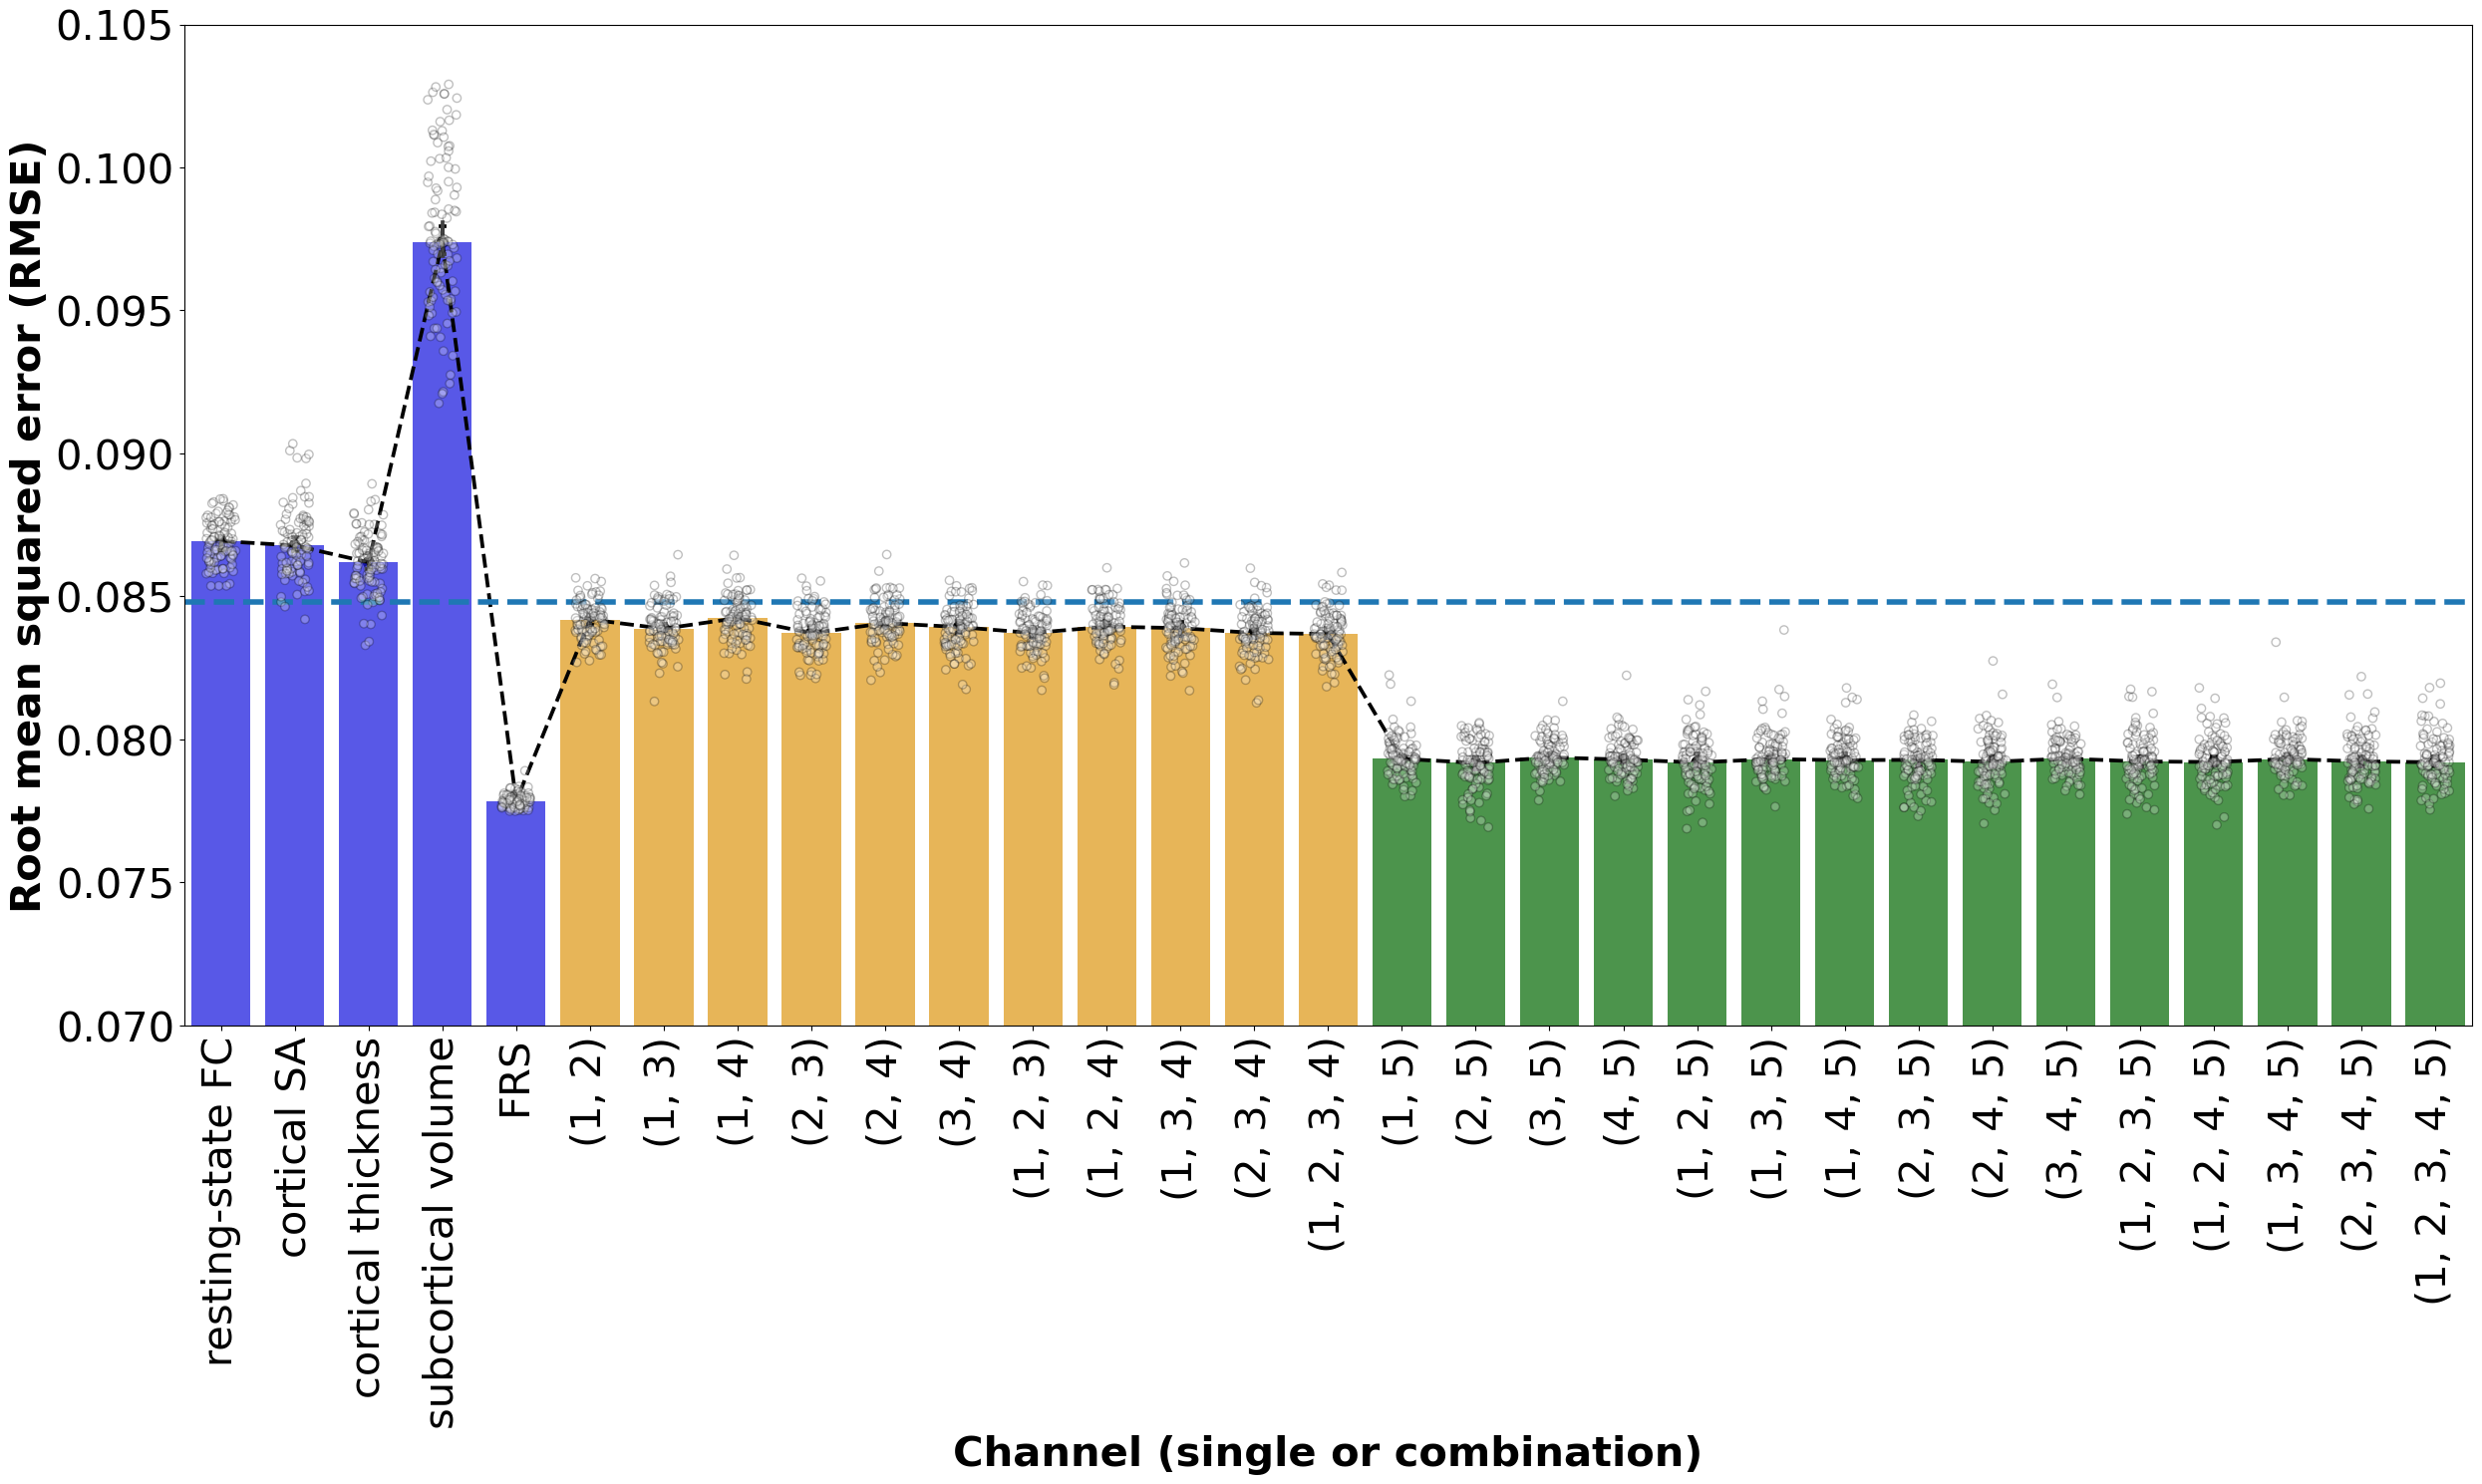

In [104]:
fig, ax = plt.subplots(figsize=(25,15))

sns.stripplot(y='value', 
              x='variable', 
              data=mc_cc_rmse_df, 
              size= 6,
              alpha=0.25,
              jitter=0.2,
              linewidth = 1,
              color = 'white',
              edgecolor ='black',
              ax = ax)

sns.pointplot(y='value', 
              x='variable', 
              data=mc_cc_rmse_df, 
              estimator = np.median, 
              seed = 0, 
              color='black',
              #errwidth=6,
              capsize=.05,
              linestyles='--',
              #scale=0.8,
              #errcolor=".05",
              ax=ax)

sns.barplot(y='value', 
            x='variable', 
            data=mc_cc_rmse_df, 
            estimator = np.median,
            #capsize=0,
            #linewidth=0.,#2.5,
            #errwidth = 0,
            #errcolor=".05", edgecolor=".05",
            alpha=0.75,
            palette = clr_palette,
            ax = ax)

ax.axhline(0.0848, ls='--', lw=4)
ax.set_ylabel(r'Root mean squared error (RMSE)', size=30, weight = 'bold')
ax.set_xlabel(r'Channel (single or combination)', size=30, weight = 'bold')

ax.tick_params(axis='y', labelsize=30)
ax.set_xticklabels(mc_cc_rmse_dict.keys(), rotation='vertical', size=30)
#ax.set_title("", size=50, weight = 'bold', loc='center')
plt.ylim([0.07, 0.105])
plt.tight_layout()
plt.savefig("/Users/amy/Desktop/coax/monte_carlo_channel_combination_rmse_092521.png", dpi=600)

In [175]:
single_channel_rmse_median = np.median(single_channel_rmse,axis=0)
print(single_channel_rmse_median)

[0.08693316 0.08677713 0.08619061 0.09738002 0.07784376]


In [166]:
rmse_brain_median = np.median(rmse_brain,axis=0)
print(rmse_brain_median)
print("min", np.min(rmse_brain_median),"max", np.max(rmse_brain_median))

[0.08419075 0.08386754 0.08424117 0.08371049 0.08406332 0.08392681
 0.08371753 0.08394018 0.08388886 0.08371969 0.08368384]
min 0.08368384282141288 max 0.08424117109567589


In [168]:
rmse_FI_median = np.median(rmse_FI,axis=0)
print(rmse_FI_median)
print("min", np.min(rmse_FI_median),"max", np.max(rmse_FI_median))

[0.0793177  0.07917541 0.0793677  0.07929217 0.07919121 0.07930734
 0.07927035 0.07928218 0.0792127  0.07932509 0.07922609 0.07920589
 0.07930922 0.07922855 0.07919756]
min 0.07917541110479065 max 0.07936769714394538


In [167]:
rmse_brain_mean = np.mean(rmse_brain,axis=0)
print(rmse_brain_mean)
print("min", np.min(rmse_brain_mean),"max", np.max(rmse_brain_mean))

[0.08415267 0.0839489  0.08422532 0.08375594 0.08408576 0.08388822
 0.08375455 0.08400584 0.083878   0.0837344  0.08373846]
min 0.08373439887995572 max 0.08422531692059083


In [169]:
rmse_FI_mean = np.mean(rmse_FI,axis=0)
print(rmse_FI_mean)
print("min", np.min(rmse_FI_mean),"max", np.max(rmse_FI_mean))

[0.0793973  0.07914291 0.0793921  0.07937239 0.07924069 0.07946522
 0.07941249 0.07920315 0.07925853 0.079407   0.07930751 0.07927292
 0.07944316 0.07929831 0.07932583]
min 0.07914291326851937 max 0.07946521729581557


In [95]:
f = open('/Users/amy/Desktop/coax/group/n_324/mc_comb_metrics.pckl', 'rb')
[comb_r, comb_r2, comb_bf, str_subset] = pickle.load(f) # r, r2, bf (+ str_subset for channel combination order)
f.close()


In [28]:
comb_r2.shape

(100, 26)

In [42]:
comb_bf.shape

(100, 26)

In [43]:
# single channel stacked predictions -> use to get single channel r, r2
f = open('/Users/amy/Desktop/coax/group/n_324/mc_single_channel_predictions.pckl', 'rb')
[mc_stacked_predictions] = pickle.load(f)
f.close()

In [44]:
mc_stacked_predictions.shape

(100, 5, 324)

In [45]:
# y_pred(100*26*324), y(100*324) (+ str_subset for channel combination order)
f = open('/Users/amy/Desktop/coax/group/n_324/mc_comb_y_predicted.pckl', 'rb')
[comb_y_pred, mc_y, str_subset] = pickle.load(f)
f.close()

In [46]:
comb_y_pred.shape

(100, 26, 324)

In [47]:
mc_y.shape

(100, 324)

In [53]:
n_splits = 100

In [62]:

single_channel_r = np.zeros(shape=(n_splits,n_sources))
split = 0
for x in mc_stacked_predictions: #method of iterating through numpy arrays
    channel = 0
    for y_pred in x: 
        #print("x", x.shape)
        #print("y_pred", y_pred.shape)
        single_channel_r[split,channel], p = pearsonr(y_pred, mc_y[split,:])
        #print(pearsonr(y_pred, mc_y[split,:]))
        channel += 1
    split += 1

In [64]:
single_channel_r.shape

(100, 5)

In [65]:
single_channel_r2 = np.zeros(shape=(n_splits,n_sources))
split = 0
for x in mc_stacked_predictions: #method of iterating through numpy arrays
    channel = 0
    for y_pred in x: 
        single_channel_r2[split,channel] = r2_score(mc_y[split,:], y_pred)
        channel += 1
    split += 1

In [67]:
single_channel_r2.shape

(100, 5)

In [68]:
# single channel r, r2
f = open('/Users/amy/Desktop/coax/group/n_324/mc_single_channel_r_r2.pckl', 'wb')
pickle.dump([single_channel_r, single_channel_r2],f)
f.close()

In [44]:
# single channel r, r2
f = open('/Users/amy/Desktop/coax/group/n_324/mc_single_channel_r_r2.pckl', 'rb')
[single_channel_r, single_channel_r2] = pickle.load(f)
f.close()

In [97]:
r_brain = comb_r[:,brain_i]
r_FI = comb_r[:,FI_i]

r2_brain = comb_r2[:,brain_i]
r2_FI = comb_r2[:,FI_i]

In [98]:
r2_brain

array([[-0.00665212, -0.01179659, -0.04738314, ..., -0.03653577,
         0.03908158,  0.02142957],
       [-0.03934683, -0.02278848, -0.02433562, ..., -0.01810145,
        -0.01920792, -0.01824876],
       [-0.18124392,  0.01296972, -0.0166209 , ...,  0.00529213,
        -0.17210836, -0.1246844 ],
       ...,
       [-0.12500841, -0.03850054, -0.07812072, ..., -0.073512  ,
        -0.1280647 , -0.11158106],
       [ 0.03552351,  0.05649584, -0.0036522 , ...,  0.05290397,
         0.08066797,  0.07968097],
       [ 0.01244987,  0.00798311, -0.01027304, ...,  0.01506849,
         0.01073024,  0.03501392]])

In [99]:
#r sorted in order of subset (i.e. increasing complexity) with FI separated

single_channels = ['resting-state FC', 'cortical SA', 'cortical thickness', 'subcortical volume', 'FRS']

mc_cc_r_dict = dict()

for  j, name in enumerate(single_channels):
    mc_cc_r_dict[name] = single_channel_r[:, j] 

for  i, name in enumerate(str_brain):
    mc_cc_r_dict[name] = r_brain[:, i] 
    
for  k, name in enumerate(str_FI):
    mc_cc_r_dict[name] = r_FI[:, k] 


mc_cc_r_df = pd.melt(pd.DataFrame(mc_cc_r_dict))

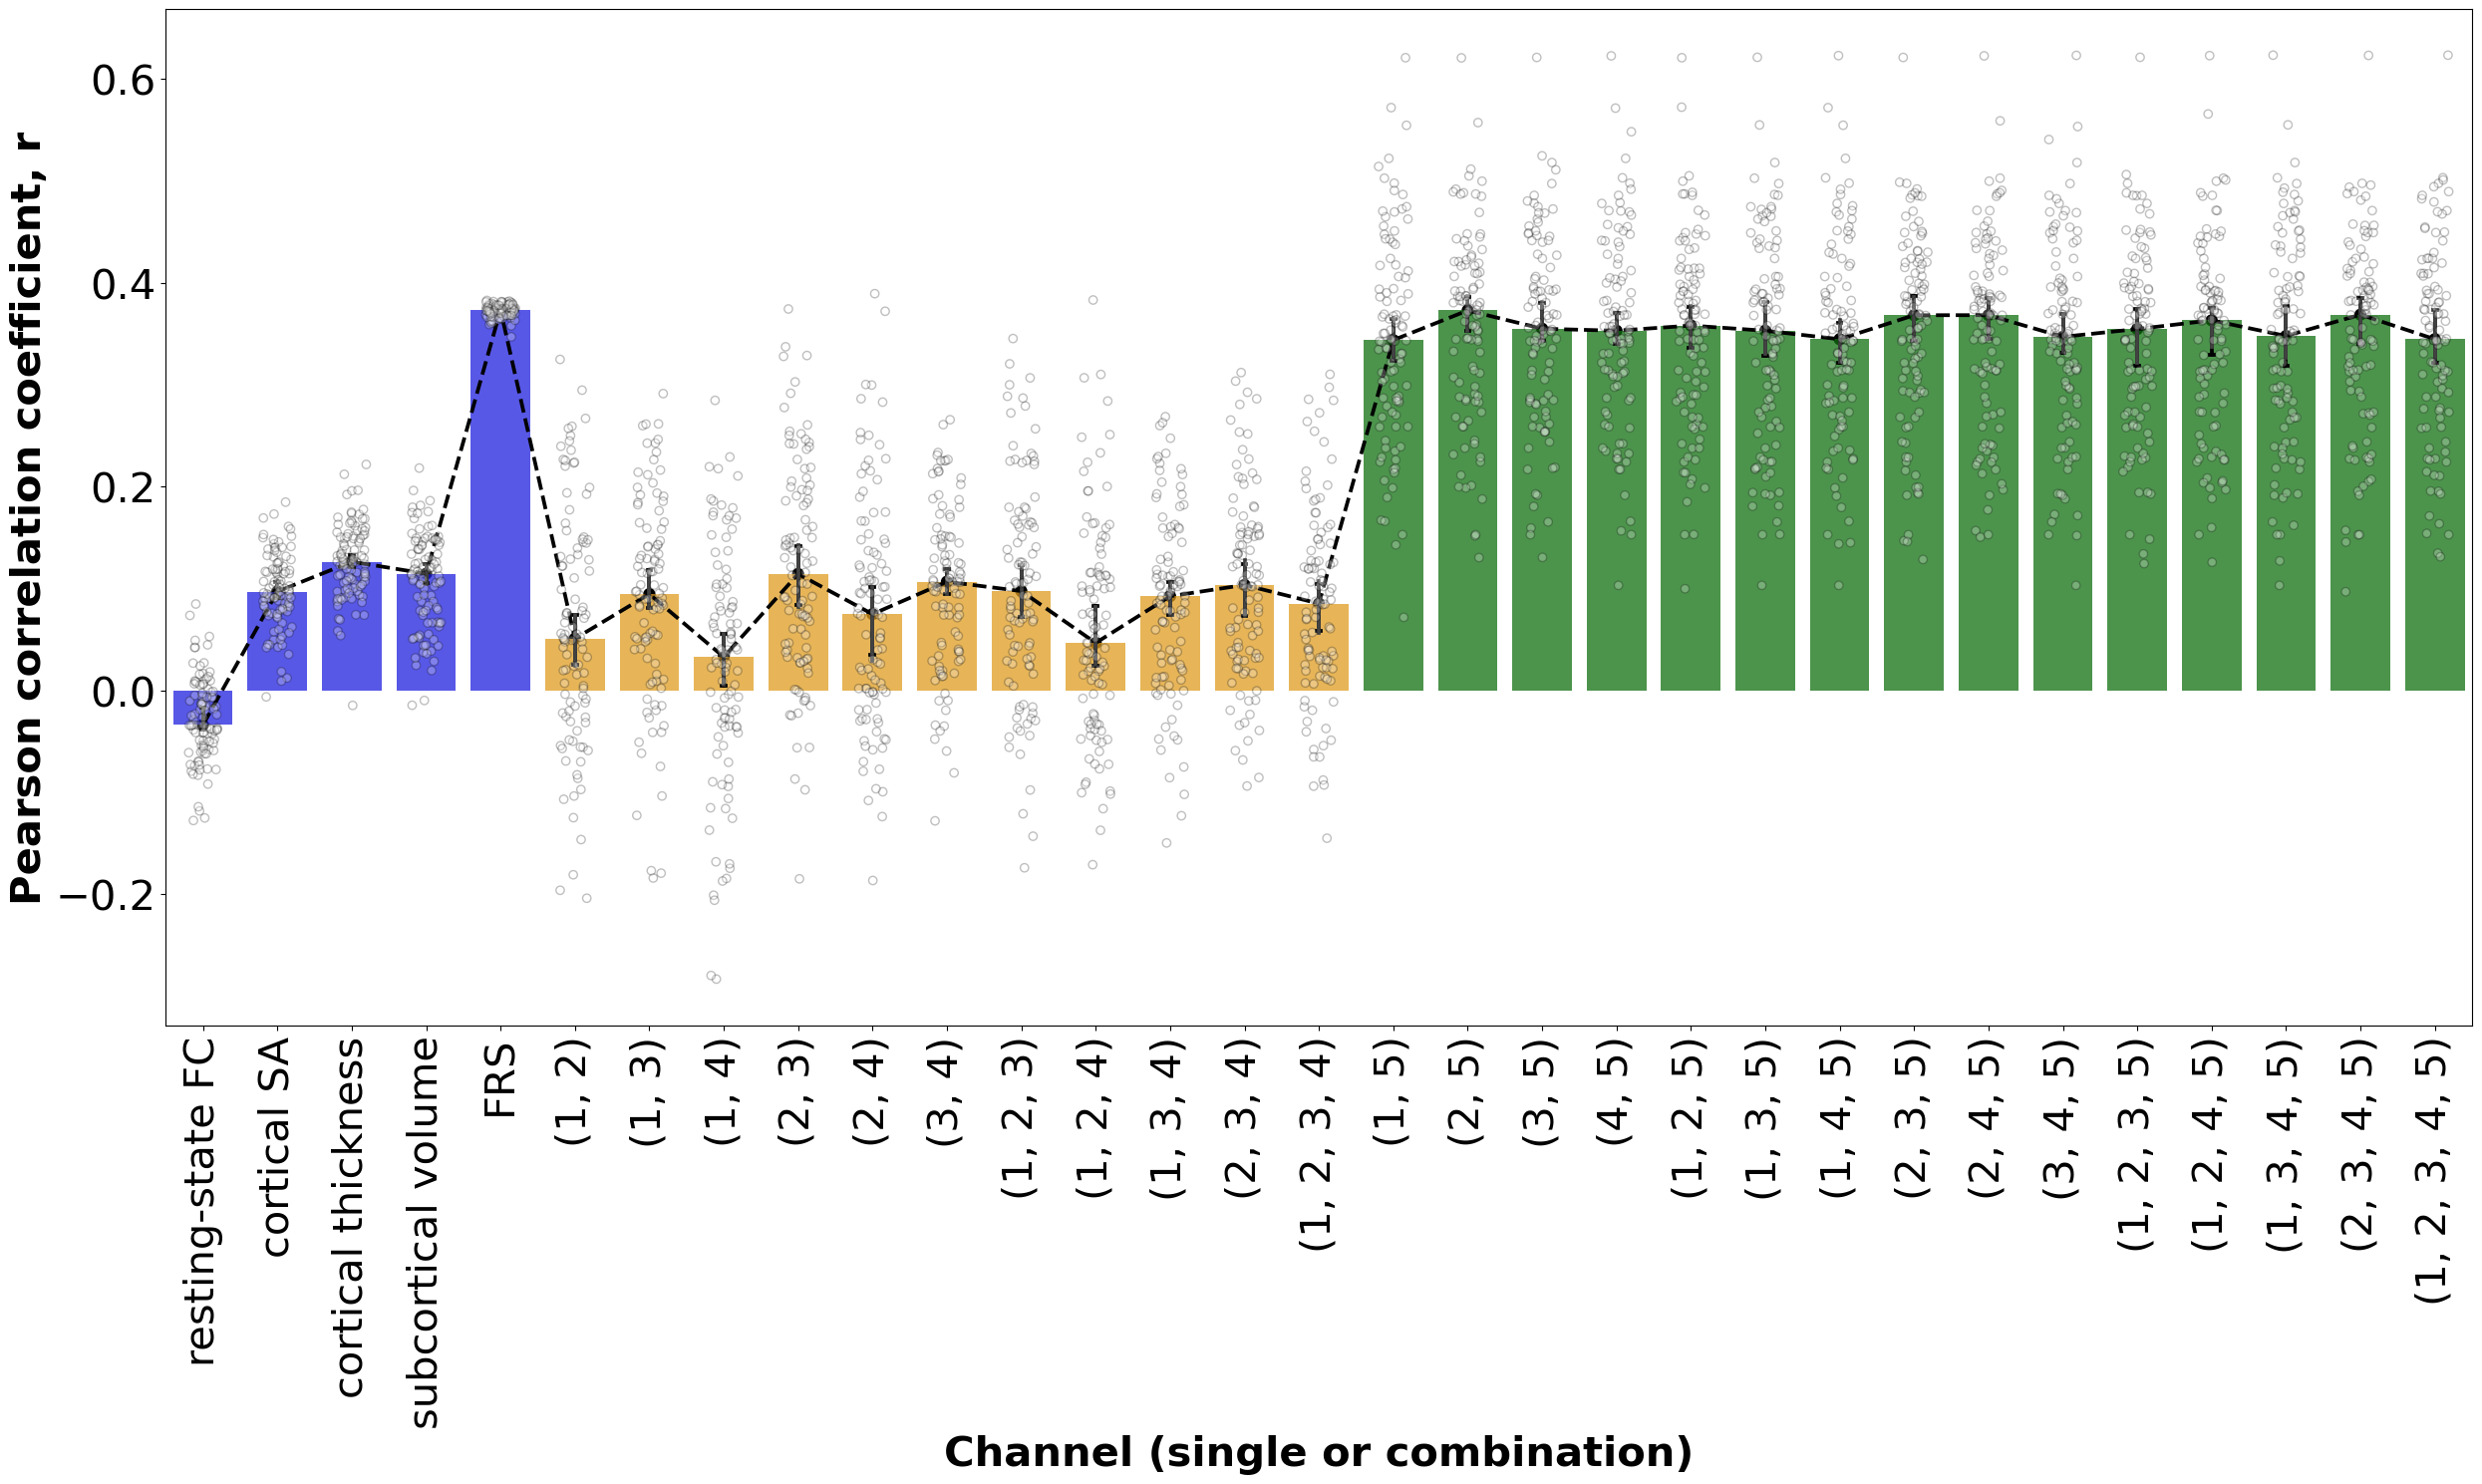

In [105]:
fig, ax = plt.subplots(figsize=(25,15))

sns.stripplot(y='value', 
              x='variable', 
              data=mc_cc_r_df, 
              size= 6,
              alpha=0.25,
              jitter=0.2,
              linewidth = 1,
              color = 'white',
              edgecolor ='black',
              ax = ax)

sns.pointplot(y='value', 
              x='variable', 
              data=mc_cc_r_df, 
              estimator = np.median, 
              seed = 0, 
              color='black',
              #errwidth=6,
              capsize=.05,
              linestyles='--',
              #scale=0.8,
              #errcolor=".05",
              ax=ax)

sns.barplot(y='value', 
            x='variable', 
            data=mc_cc_r_df, 
            estimator = np.median,
            #capsize=0,
            #linewidth=0.,#2.5,
            #errwidth = 0,
            #errcolor=".05", edgecolor=".05",
            alpha=0.75,
            palette = clr_palette,
            ax = ax)

ax.set_ylabel(r'Pearson correlation coefficient, r', size=30, weight = 'bold')
ax.set_xlabel(r'Channel (single or combination)', size=30, weight = 'bold')

ax.tick_params(axis='y', labelsize=30)
ax.set_xticklabels(mc_cc_r_dict.keys(), rotation='vertical', size=30)
#ax.set_title("", size=50, weight = 'bold', loc='center')
#plt.ylim([0.07, 0.105])
plt.tight_layout()
plt.savefig("/Users/amy/Desktop/coax/monte_carlo_channel_combination_r_092521.png", dpi=600)

In [174]:
single_channel_r_median = np.median(single_channel_r,axis=0)
print(single_channel_r_median)

[-0.03375706  0.09699214  0.126259    0.11453042  0.37319574]


In [170]:
r_brain_median = np.median(r_brain,axis=0)
print(r_brain_median)
print("min", np.min(r_brain_median),"max", np.max(r_brain_median))

[0.050803   0.09453213 0.03284596 0.11425792 0.07486451 0.10666132
 0.09746201 0.04662369 0.0924174  0.10349279 0.08523801]
min 0.032845959121410896 max 0.11425792311547693


In [171]:
r_FI_median = np.median(r_FI,axis=0)
print(r_FI_median)
print("min", np.min(r_FI_median),"max", np.max(r_FI_median))

[0.34363911 0.37272977 0.35481571 0.35283377 0.35790948 0.35283377
 0.34453981 0.36803895 0.36811786 0.34686045 0.35450126 0.36301594
 0.3477053  0.36860634 0.34453981]
min 0.3436391076789018 max 0.3727297689474017


In [172]:
r_brain_mean = np.mean(r_brain,axis=0)
print(r_brain_mean)
print("min", np.min(r_brain_mean),"max", np.max(r_brain_mean))

[0.05994729 0.08957266 0.02467994 0.11776866 0.07742283 0.1013781
 0.09901084 0.05847063 0.08686418 0.1023525  0.08539952]
min 0.024679935216101356 max 0.11776866067776429


In [173]:
r_FI_mean = np.mean(r_FI,axis=0)
print(r_FI_mean)
print("min", np.min(r_FI_mean),"max", np.max(r_FI_mean))

[0.34576637 0.35897113 0.35420335 0.35467128 0.34886282 0.34467526
 0.3440636  0.35393233 0.35351821 0.34639528 0.34422139 0.34694312
 0.34455201 0.34895899 0.34283854]
min 0.342838540574284 max 0.35897113285799487


In [46]:
#r2 sorted in order of subset (i.e. increasing complexity) with FI separated

single_channels = ['resting-state FC', 'cortical SA', 'cortical thickness', 'subcortical volume', 'FRS']

mc_cc_r2_dict = dict()

for  j, name in enumerate(single_channels):
    mc_cc_r2_dict[name] = single_channel_r2[:, j] 

for  i, name in enumerate(str_brain):
    mc_cc_r2_dict[name] = comb_r2_brain[:, i] 
    
for  k, name in enumerate(str_FI):
    mc_cc_r2_dict[name] = comb_r2_FI[:, k] 


mc_cc_r2_df = pd.melt(pd.DataFrame(mc_cc_r2_dict))

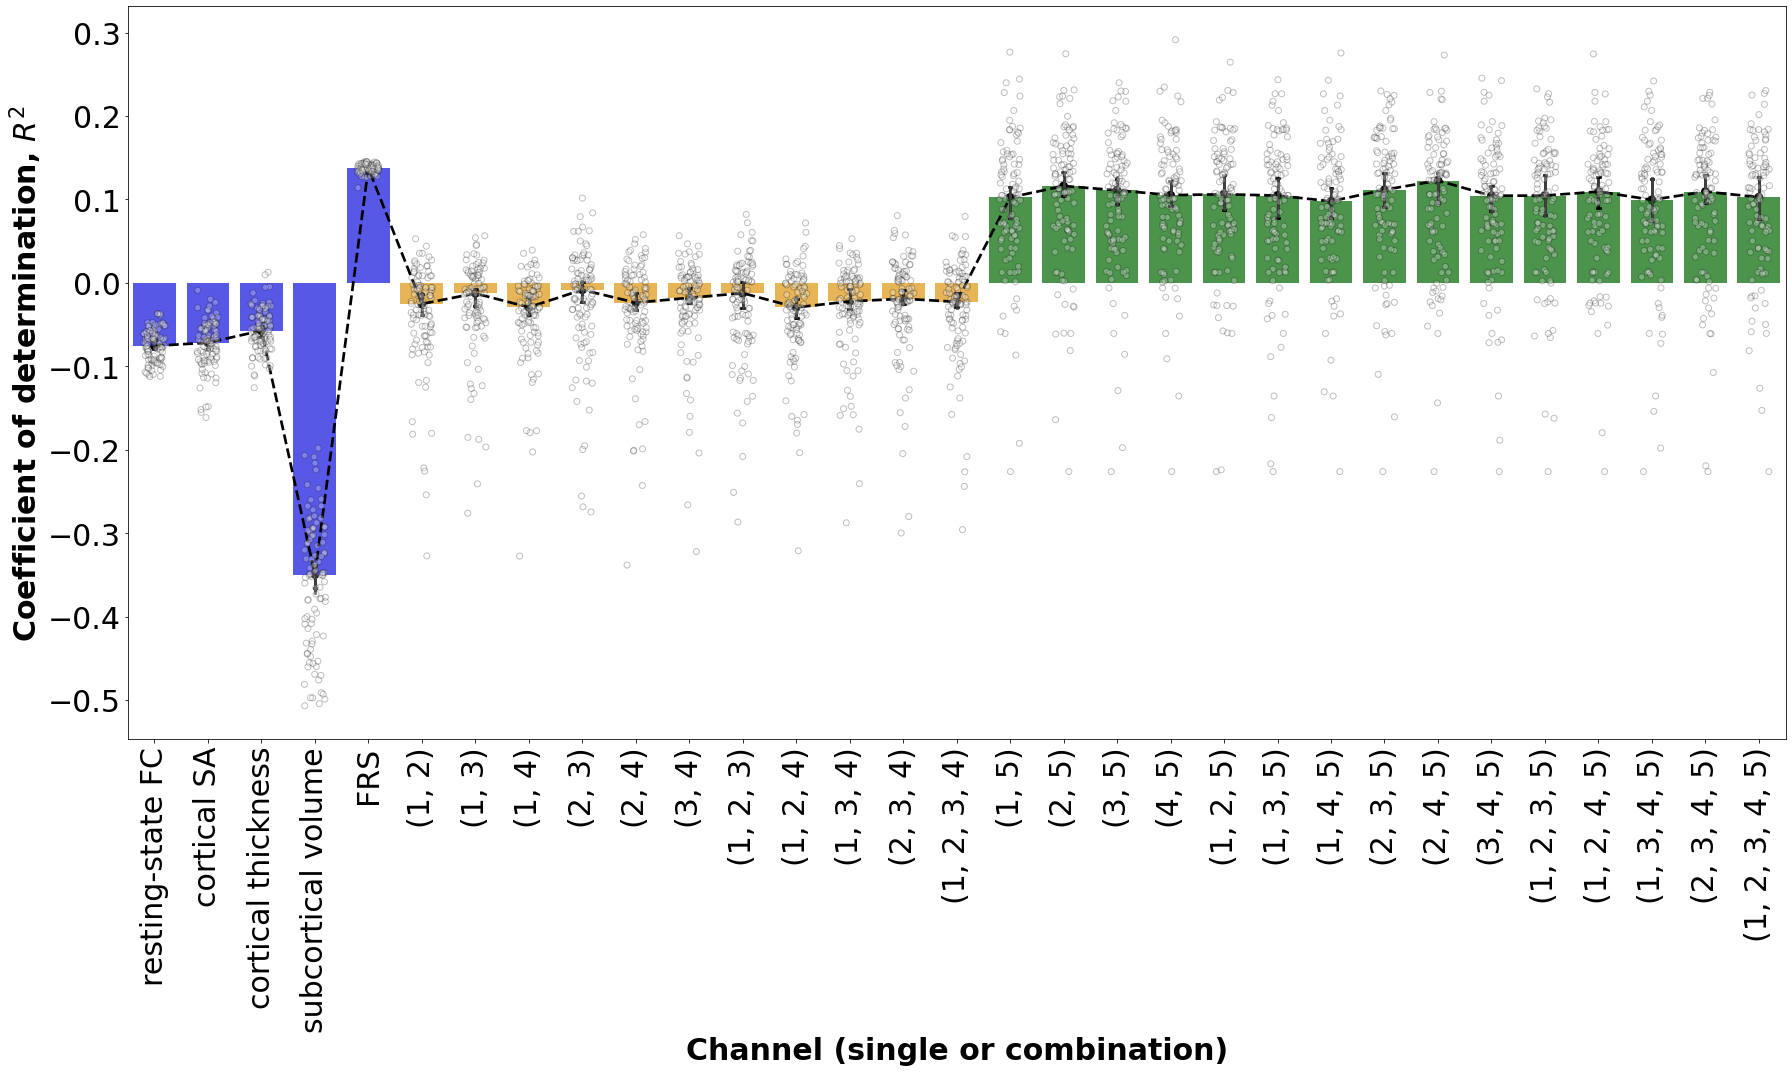

In [49]:
fig, ax = plt.subplots(figsize=(25,15))

sns.stripplot(y='value', 
              x='variable', 
              data=mc_cc_r2_df, 
              size= 6,
              alpha=0.25,
              jitter=0.2,
              linewidth = 1,
              color = 'white',
              edgecolor ='black',
              ax = ax)

sns.pointplot(y='value', 
              x='variable', 
              data=mc_cc_r2_df, 
              estimator = np.median, 
              seed = 0, 
              color='black',
              #errwidth=6,
              capsize=.05,
              linestyles='--',
              #scale=0.8,
              #errcolor=".05",
              ax=ax)

sns.barplot(y='value', 
            x='variable', 
            data=mc_cc_r2_df, 
            estimator = np.median,
            #capsize=0,
            #linewidth=0.,#2.5,
            #errwidth = 0,
            #errcolor=".05", edgecolor=".05",
            alpha=0.75,
            palette = clr_palette,
            ax = ax)

ax.set_ylabel(r'Coefficient of determination, $R^2$', size=30, weight = 'bold')
ax.set_xlabel(r'Channel (single or combination)', size=30, weight = 'bold')

ax.tick_params(axis='y', labelsize=30)
ax.set_xticklabels(mc_cc_r2_dict.keys(), rotation='vertical', size=30)
#ax.set_title("", size=50, weight = 'bold', loc='center')
#plt.ylim([0.07, 0.105])
plt.tight_layout()
plt.savefig("/Users/amy/Desktop/coax/monte_carlo_channel_combination_r2_102321.png", dpi=600)

In [90]:
mc_r2_rsFC_mean = np.mean(mc_cc_r2_dict['resting-state FC'])
mc_r2_rsFC_mean

-0.07549745353051347

In [91]:
mc_r2_rsFC_median = np.median(mc_cc_r2_dict['resting-state FC'])
mc_r2_rsFC_median

-0.075484011519383

In [92]:
mc_r2_SA_mean = np.mean(mc_cc_r2_dict['cortical SA'])
mc_r2_SA_mean

-0.07456510872124478

In [93]:
mc_r2_SA_median = np.median(mc_cc_r2_dict['cortical SA'])
mc_r2_SA_median

-0.07162698337374285

In [94]:
mc_r2_ct_mean = np.mean(mc_cc_r2_dict['cortical thickness'])
mc_r2_ct_mean

-0.05714603272562838

In [95]:
mc_r2_ct_median = np.median(mc_cc_r2_dict['cortical thickness'])
mc_r2_ct_median

-0.05719004217415169

In [96]:
mc_r2_vol_mean = np.mean(mc_cc_r2_dict['subcortical volume'])
mc_r2_vol_mean

-0.35887547608614595

In [97]:
mc_r2_vol_median = np.median(mc_cc_r2_dict['subcortical volume'])
mc_r2_vol_median

-0.3494997088636941

In [98]:
mc_r2_frs_mean = np.mean(mc_cc_r2_dict['FRS'])
mc_r2_frs_mean

0.13745341143269463

In [99]:
mc_r2_frs_median = np.median(mc_cc_r2_dict['FRS'])
mc_r2_frs_median

0.1376557557571233

In [153]:
str_subset

['(0, 1)',
 '(0, 2)',
 '(0, 3)',
 '(0, 4)',
 '(1, 2)',
 '(1, 3)',
 '(1, 4)',
 '(2, 3)',
 '(2, 4)',
 '(3, 4)',
 '(0, 1, 2)',
 '(0, 1, 3)',
 '(0, 1, 4)',
 '(0, 2, 3)',
 '(0, 2, 4)',
 '(0, 3, 4)',
 '(1, 2, 3)',
 '(1, 2, 4)',
 '(1, 3, 4)',
 '(2, 3, 4)',
 '(0, 1, 2, 3)',
 '(0, 1, 2, 4)',
 '(0, 1, 3, 4)',
 '(0, 2, 3, 4)',
 '(1, 2, 3, 4)',
 '(0, 1, 2, 3, 4)']

In [158]:
np.mean(comb_r2,axis=0)

array([-0.03974408, -0.02885016, -0.03979876,  0.09247413, -0.0253852 ,
       -0.03382231,  0.10267937, -0.02863283,  0.09744415,  0.09794329,
       -0.02924835, -0.03924182,  0.09472994, -0.03252821,  0.08769853,
        0.08934676, -0.02811214,  0.09853585,  0.09754525,  0.08942765,
       -0.03275658,  0.08970097,  0.09217807,  0.08759147,  0.09276155,
        0.08790889])

In [159]:
np.median(comb_r2,axis=0)

array([-0.02516752, -0.0125372 , -0.02918329,  0.10250673, -0.00828   ,
       -0.02363983,  0.11618585, -0.01789118,  0.11101815,  0.10522379,
       -0.01220374, -0.02931873,  0.10624657, -0.02214362,  0.10471828,
        0.09784402, -0.01895784,  0.11161212,  0.12264676,  0.10447687,
       -0.02270203,  0.10468514,  0.10945232,  0.09958362,  0.10941058,
        0.10274083])

In [27]:
# comb_bic + str_subset
f = open('/Users/amy/Desktop/coax/group/n_324/mc_comb_bic.pckl', 'rb')
[comb_bic, str_subset] = pickle.load(f)
f.close()

# step1_bic 
f = open('/Users/amy/Desktop/coax/group/n_324/mc_single_channel_bic.pckl', 'rb')
[step1_bics] = pickle.load(f)
f.close()

In [43]:
np.mean(comb_bf,axis=0)

array([2.60591696, 2.72662011, 1.66853339, 4.56086244, 2.62301528,
       1.79076396, 4.31019421, 2.39271055, 4.42589977, 4.52022783,
       2.93587565, 2.73564093, 4.50804246, 2.44535408, 4.54185665,
       4.67608677, 2.62578198, 4.43883909, 4.47483021, 4.58683181,
       3.10563492, 4.48159071, 4.55264048, 4.69578673, 4.48308185,
       4.58643628])

In [44]:
np.median(comb_bf,axis=0)

array([2.12709993, 2.24838648, 2.05280713, 4.50804893, 2.62679072,
       2.0444962 , 4.23675623, 2.2407631 , 4.39420801, 4.5336004 ,
       2.59627943, 2.36084161, 4.54184656, 2.16442249, 4.50932058,
       4.66692301, 2.56942118, 4.37762965, 4.48339209, 4.58510388,
       2.60712567, 4.5529652 , 4.52103826, 4.71170475, 4.5116913 ,
       4.6149336 ])

In [30]:
#r2 sorted in order of subset (i.e. increasing complexity) with FI separated

single_channels = ['resting-state FC', 'cortical SA', 'cortical thickness', 'subcortical volume', 'FRS']

mc_cc_bic_dict = dict()

for  j, name in enumerate(single_channels):
    mc_cc_bic_dict[name] = step1_bics[:, j] 

for  i, name in enumerate(str_brain):
    mc_cc_bic_dict[name] = comb_bic_brain[:, i] 
    
for  k, name in enumerate(str_FI):
    mc_cc_bic_dict[name] = comb_bic_FI[:, k] 


mc_cc_bic_df = pd.melt(pd.DataFrame(mc_cc_bic_dict))

In [59]:
np.median(step1_bics, axis=0)

array([ 8.24540452e+04,  3.06180453e+02,  3.05064291e+02, -3.89933492e+01,
       -3.32893760e+02])

In [60]:
np.median(comb_bic, axis=0)

array([-312.89482578, -314.21593009, -313.50282162, -321.88225303,
       -314.09644511, -313.397858  , -322.22634398, -313.5562861 ,
       -321.73156789, -322.17369328, -313.99475791, -313.53101289,
       -321.52896732, -313.80086084, -321.54956124, -321.5748848 ,
       -313.92204401, -321.91833635, -321.72395562, -321.68875523,
       -314.13162145, -321.02453172, -321.53118376, -320.89646736,
       -321.63697759, -321.18640895])

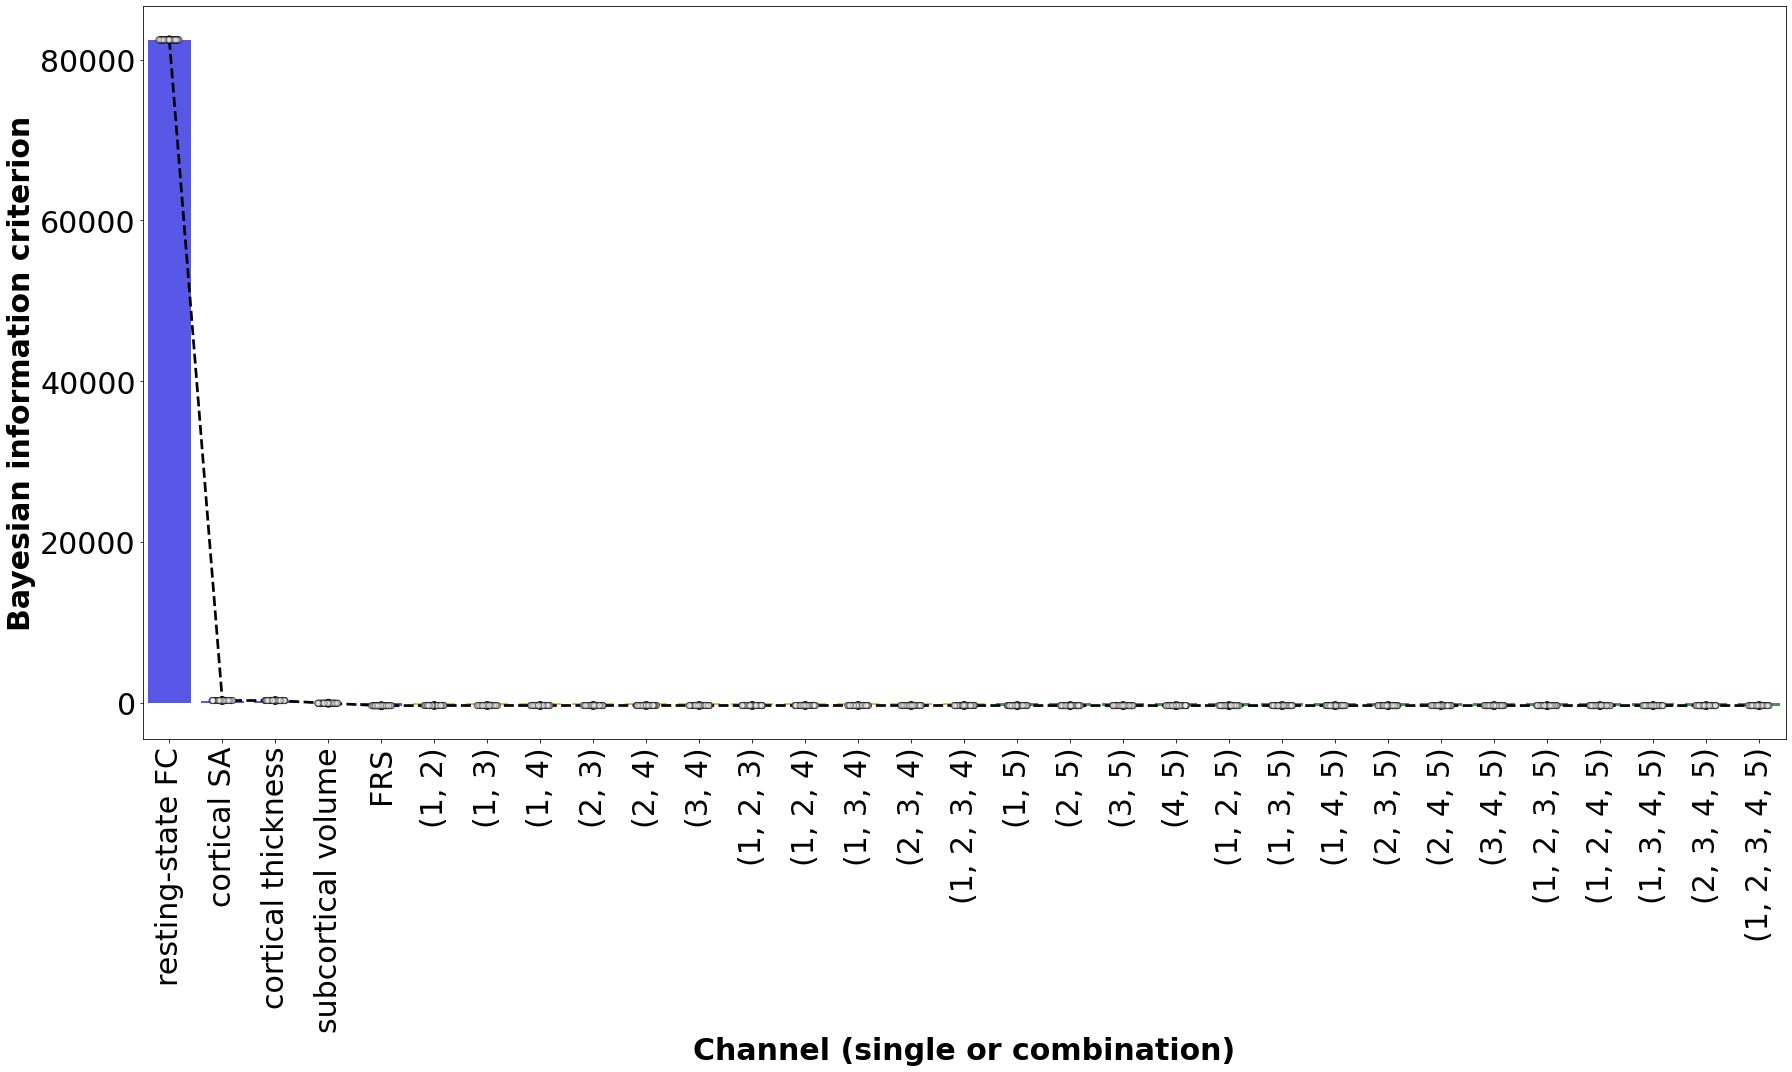

In [51]:
fig, ax = plt.subplots(figsize=(25,15))

sns.stripplot(y='value', 
              x='variable', 
              data=mc_cc_bic_df, 
              size= 6,
              alpha=0.25,
              jitter=0.2,
              linewidth = 1,
              color = 'white',
              edgecolor ='black',
              ax = ax)

sns.pointplot(y='value', 
              x='variable', 
              data=mc_cc_bic_df, 
              estimator = np.median, 
              seed = 0, 
              color='black',
              #errwidth=6,
              capsize=.05,
              linestyles='--',
              #scale=0.8,
              #errcolor=".05",
              ax=ax)

sns.barplot(y='value', 
            x='variable', 
            data=mc_cc_bic_df, 
            estimator = np.median,
            #capsize=0,
            #linewidth=0.,#2.5,
            #errwidth = 0,
            #errcolor=".05", edgecolor=".05",
            alpha=0.75,
            palette = clr_palette,
            ax = ax)

ax.set_ylabel(r'Bayesian information criterion', size=30, weight = 'bold')
ax.set_xlabel(r'Channel (single or combination)', size=30, weight = 'bold')

ax.tick_params(axis='y', labelsize=30)
ax.set_xticklabels(mc_cc_bic_dict.keys(), rotation='vertical', size=30)
#ax.set_title("", size=50, weight = 'bold', loc='center')
#plt.ylim([0.07, 0.105])
plt.tight_layout()
plt.savefig("/Users/amy/Desktop/coax/monte_carlo_channel_combination_bic_102321.png", dpi=600)

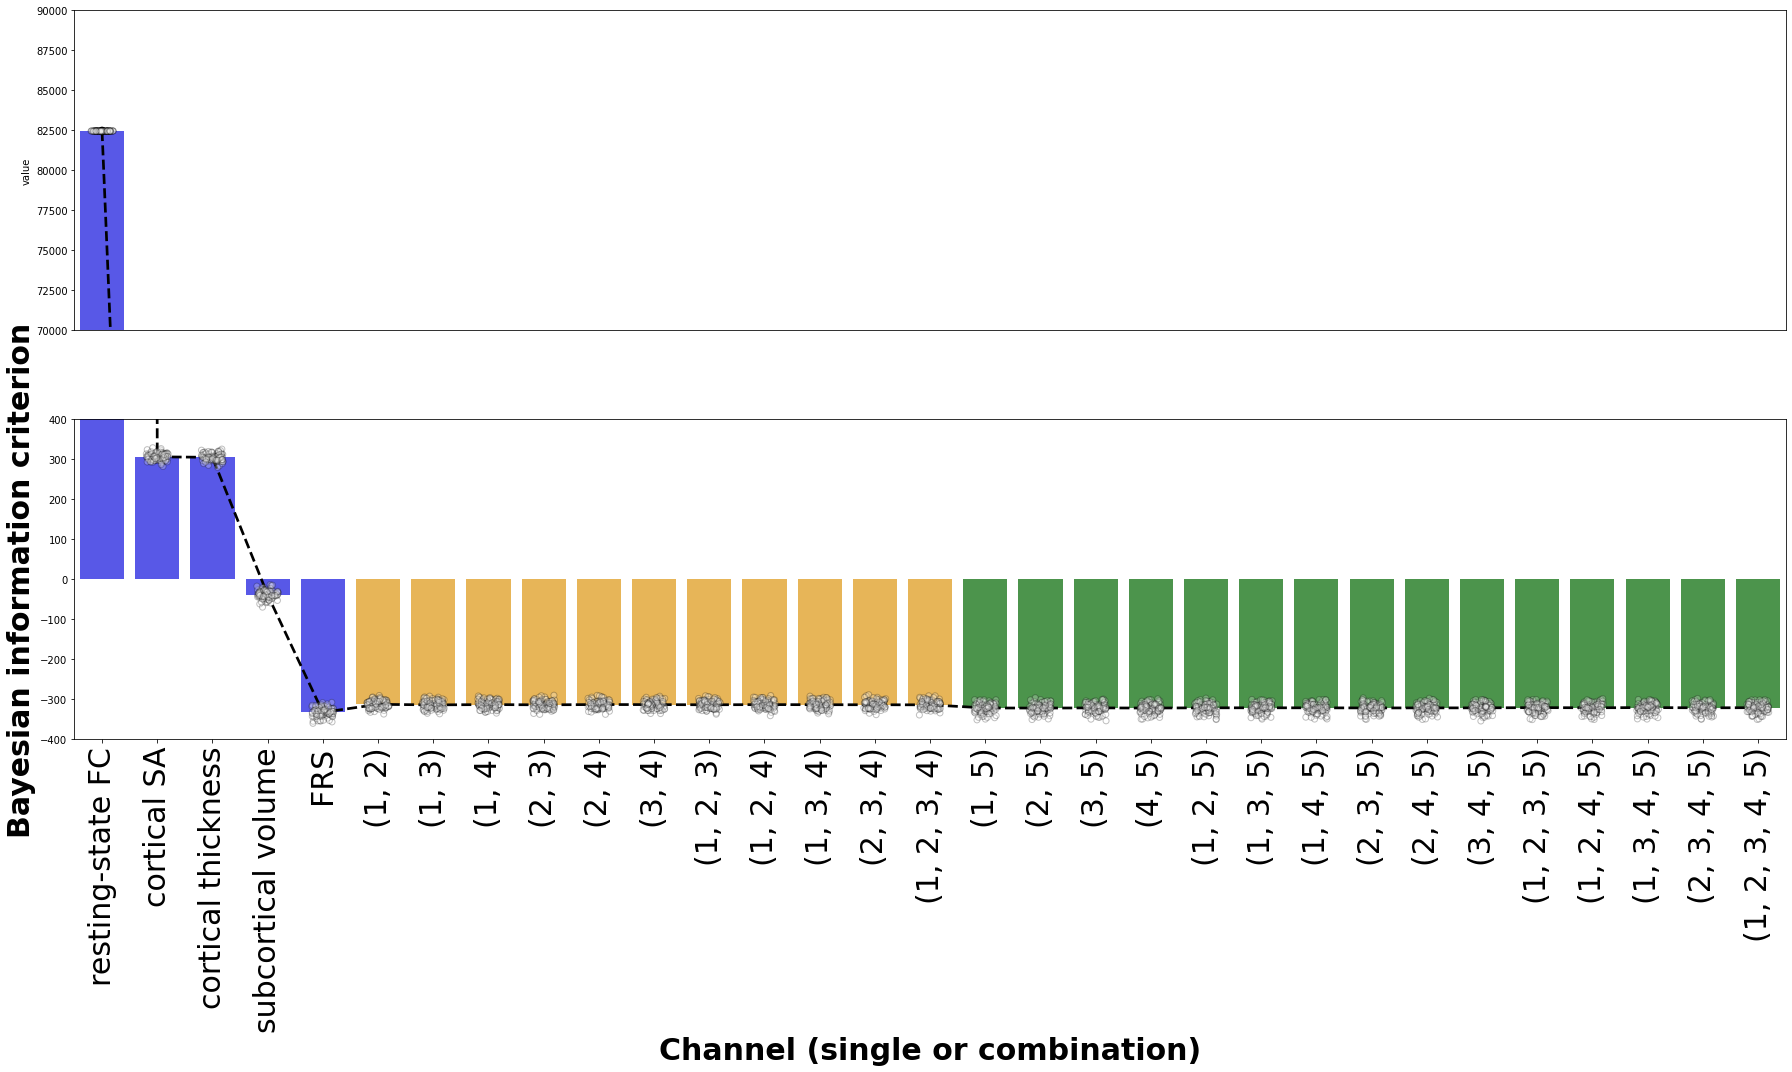

In [57]:
fig, (ax1, ax2) = plt.subplots(figsize=(25,15), ncols=1, nrows=2, sharex=True)

sns.stripplot(y='value', 
              x='variable', 
              data=mc_cc_bic_df, 
              size= 6,
              alpha=0.25,
              jitter=0.2,
              linewidth = 1,
              color = 'white',
              edgecolor ='black',
              ax = ax1)

sns.pointplot(y='value', 
              x='variable', 
              data=mc_cc_bic_df, 
              estimator = np.median, 
              seed = 0, 
              color='black',
              #errwidth=6,
              capsize=.05,
              linestyles='--',
              #scale=0.8,
              #errcolor=".05",
              ax=ax1)

sns.barplot(y='value', 
            x='variable', 
            data=mc_cc_bic_df, 
            estimator = np.median,
            #capsize=0,
            #linewidth=0.,#2.5,
            #errwidth = 0,
            #errcolor=".05", edgecolor=".05",
            alpha=0.75,
            palette = clr_palette,
            ax = ax1)

sns.stripplot(y='value', 
              x='variable', 
              data=mc_cc_bic_df, 
              size= 6,
              alpha=0.25,
              jitter=0.2,
              linewidth = 1,
              color = 'white',
              edgecolor ='black',
              ax = ax2)

sns.pointplot(y='value', 
              x='variable', 
              data=mc_cc_bic_df, 
              estimator = np.median, 
              seed = 0, 
              color='black',
              #errwidth=6,
              capsize=.05,
              linestyles='--',
              #scale=0.8,
              #errcolor=".05",
              ax=ax2)

sns.barplot(y='value', 
            x='variable', 
            data=mc_cc_bic_df, 
            estimator = np.median,
            #capsize=0,
            #linewidth=0.,#2.5,
            #errwidth = 0,
            #errcolor=".05", edgecolor=".05",
            alpha=0.75,
            palette = clr_palette,
            ax = ax2)

ax1.set_ylim(70000, 90000)
ax2.set_ylim(-400, 400)
ax1.get_xaxis().set_visible(False)

#d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
#kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
#ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
#ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

#kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
#ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
#ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax2.set_ylabel(r'Bayesian information criterion', size=30, weight = 'bold')
ax2.set_xlabel(r'Channel (single or combination)', size=30, weight = 'bold')

ax.tick_params(axis='y', labelsize=30)
ax2.set_xticklabels(mc_cc_bic_dict.keys(), rotation='vertical', size=30)
#ax.set_title("", size=50, weight = 'bold', loc='center')
#plt.ylim([0.07, 0.105])
plt.tight_layout()
#plt.savefig("/Users/amy/Desktop/coax/monte_carlo_channel_combination_bic_102321.png", dpi=600)

In [33]:
from brokenaxes import brokenaxes #doesn't work with df

fig = plt.subplots(figsize=(25,15))

bax = brokenaxes(ylims=((-400, 400), (77500, 85000)), hspace=.05)

sns.stripplot(y='value', 
              x='variable', 
              data=mc_cc_bic_df, 
              size= 6,
              alpha=0.25,
              jitter=0.2,
              linewidth = 1,
              color = 'white',
              edgecolor ='black',
              ax=bax)

sns.pointplot(y='value', 
              x='variable', 
              data=mc_cc_bic_df, 
              estimator = np.median, 
              seed = 0, 
              color='black',
              #errwidth=6,
              capsize=.05,
              linestyles='--',
              #scale=0.8,
              #errcolor=".05",
              ax=bax)

sns.barplot(y='value', 
            x='variable', 
            data=mc_cc_bic_df, 
            estimator = np.median,
            #capsize=0,
            #linewidth=0.,#2.5,
            #errwidth = 0,
            #errcolor=".05", edgecolor=".05",
            alpha=0.75,
            palette = clr_palette,
            ax=bax)

bax.set_ylabel(r'Bayesian information criterion', size=30, weight = 'bold')
bax.set_xlabel(r'Channel (single or combination)', size=30, weight = 'bold')

bax.big_ax.tick_params(axis='y', labelsize=30)
bax.big_ax.set_xticklabels(mc_cc_bic_dict.keys(), rotation='vertical', size=30)
#ax.set_title("", size=50, weight = 'bold', loc='center')
#plt.ylim([0.07, 0.105])
plt.tight_layout()
#plt.savefig("/Users/amy/Desktop/coax/monte_carlo_channel_combination_bic_102321.png", dpi=600)

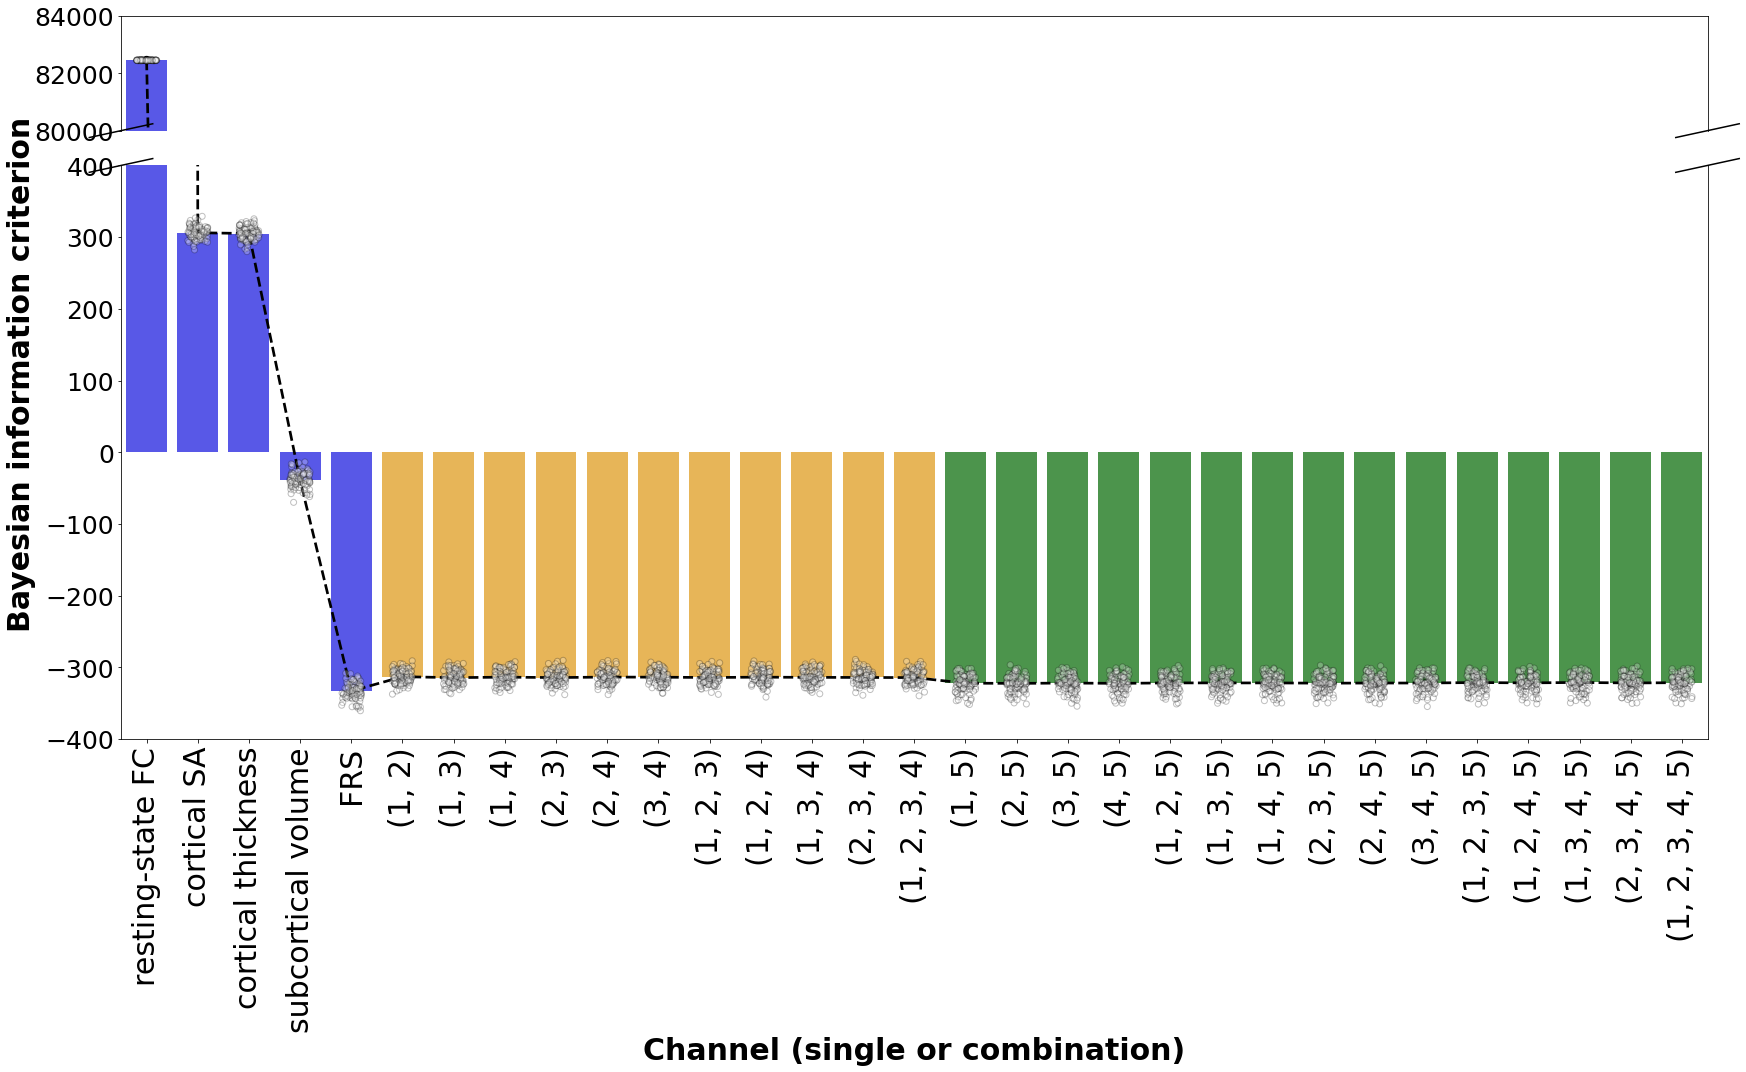

In [58]:
import matplotlib.gridspec as gridspec


ylim = [80000, 84000]
ylim2  = [-400, 400]
ylimratio = (ylim[1]-ylim[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
ylim2ratio = (ylim2[1]-ylim2[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])

gs = gridspec.GridSpec(2, 1, height_ratios=[ylim2ratio, ylimratio])
fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

sns.stripplot(y='value', 
              x='variable', 
              data=mc_cc_bic_df, 
              size= 6,
              alpha=0.25,
              jitter=0.2,
              linewidth = 1,
              color = 'white',
              edgecolor ='black',
              ax=ax1)

sns.pointplot(y='value', 
              x='variable', 
              data=mc_cc_bic_df, 
              estimator = np.median, 
              seed = 0, 
              color='black',
              #errwidth=6,
              capsize=.05,
              linestyles='--',
              #scale=0.8,
              #errcolor=".05",
              ax=ax1)

sns.barplot(y='value', 
            x='variable', 
            data=mc_cc_bic_df, 
            estimator = np.median,
            #capsize=0,
            #linewidth=0.,#2.5,
            #errwidth = 0,
            #errcolor=".05", edgecolor=".05",
            alpha=0.75,
            palette = clr_palette,
            ax=ax1)

sns.stripplot(y='value', 
              x='variable', 
              data=mc_cc_bic_df, 
              size= 6,
              alpha=0.25,
              jitter=0.2,
              linewidth = 1,
              color = 'white',
              edgecolor ='black',
              ax=ax2)

sns.pointplot(y='value', 
              x='variable', 
              data=mc_cc_bic_df, 
              estimator = np.median, 
              seed = 0, 
              color='black',
              #errwidth=6,
              capsize=.05,
              linestyles='--',
              #scale=0.8,
              #errcolor=".05",
              ax=ax2)

sns.barplot(y='value', 
            x='variable', 
            data=mc_cc_bic_df, 
            estimator = np.median,
            #capsize=0,
            #linewidth=0.,#2.5,
            #errwidth = 0,
            #errcolor=".05", edgecolor=".05",
            alpha=0.75,
            palette = clr_palette,
            ax=ax2)

ax1.set_ylim(ylim) #top subplot
ax2.set_ylim(ylim2) #bottom subplot

plt.subplots_adjust(hspace=0.01)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.xaxis.set_ticks_position('none')
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

ax1.tick_params(axis='y', labelsize=25)
ax2.tick_params(axis='y', labelsize=25)
ax2.set_xticklabels(mc_cc_bic_dict.keys(), rotation='vertical', size=30)

ax1.set_xlabel('')
ax1.set_ylabel('')
ax2.set_xlabel(r'Channel (single or combination)', size=30, weight = 'bold')
ax2.set_ylabel(r'Bayesian information criterion', size=30, weight = 'bold')
ax2.yaxis.set_label_coords(0.05, 0.65, transform=fig.transFigure)

kwargs = dict(color='k', clip_on=False)
xlim = ax1.get_xlim()
dx = .02*(xlim[1]-xlim[0])
dy = .01*(ylim[1]-ylim[0])/ylim2ratio
ax1.plot((xlim[0]-dx,xlim[0]+dx), (ylim[0]-dy,ylim[0]+dy), **kwargs)
ax1.plot((xlim[1]-dx,xlim[1]+dx), (ylim[0]-dy,ylim[0]+dy), **kwargs)
dy = .01*(ylim2[1]-ylim2[0])/ylimratio
ax2.plot((xlim[0]-dx,xlim[0]+dx), (ylim2[1]-dy,ylim2[1]+dy), **kwargs)
ax2.plot((xlim[1]-dx,xlim[1]+dx), (ylim2[1]-dy,ylim2[1]+dy), **kwargs)
ax1.set_xlim(xlim)
ax2.set_xlim(xlim)







#ax.set_title("", size=50, weight = 'bold', loc='center')

plt.tight_layout()
#plt.savefig("/Users/amy/Desktop/coax/monte_carlo_channel_combination_bic_102521.png", dpi=600)

#### LR: FRS vs. IMT

In [16]:
FRS = cov_data_imputed.reshape(-1,)

In [17]:
x_ticks = np.arange(-15,22.5,2.5)
y_ticks = np.arange(0.4,0.95,0.05)
x_ticks

array([-15. , -12.5, -10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,
         7.5,  10. ,  12.5,  15. ,  17.5,  20. ])

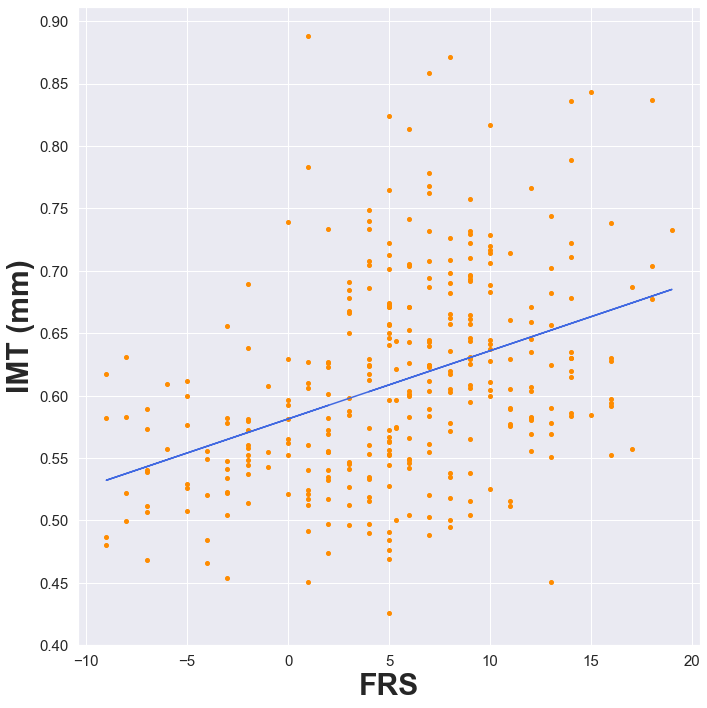

In [18]:
sns.set()

fig, axes = plt.subplots(figsize=(10,10))

#calculate line of best fit
slope, line_intercept, r_value, p_value, std_err = linregress(FRS, y)
line = slope*FRS + line_intercept

axes.scatter(FRS, y, color='darkorange', s=16)
axes.plot(FRS, line, color='royalblue')

axes.set_xlabel(r'FRS', size=30, weight = 'bold')
axes.set_ylabel(r'IMT (mm)', size=30, weight = 'bold')
axes.tick_params(axis='x', labelsize = 15)
axes.tick_params(axis='y', labelsize = 15)
plt.yticks(np.round(y_ticks,2))
#plt.xticks(np.round(x_ticks,2))
plt.tight_layout()
plt.savefig("/Users/amy/Desktop/coax/FRS_IMT_111621.png", dpi=600)



#ax.xaxis.set_ticklabels(np.round(xticks,2))


In [110]:
cov_data_imputed.reshape(-1,).shape

(324,)

In [115]:
y.shape

(324,)

In [149]:
r_value

0.38573131614254363

In [150]:
p_value

6.16672138521987e-13

### TABLE 1

In [ ]:
def extract_outcome_measure(n_subj, subject_list, outcome_file, ID_column_name, outcome_column_name):

    subjects = subject_list.values.reshape(n_subj,)
    tmp_df = pd.read_csv(outcome_file, usecols=[ID_column_name, outcome_column_name])
    y_tmp = tmp_df.loc[tmp_df[ID_column_name].isin(subjects)]
    y = y_tmp[outcome_column_name].values
    print(outcome_column_name + " loaded")

    return y, y_tmp #df coming back with labels

In [8]:
#extract variables
columns = ["ID", "BMI", "age", "sbp.sit", "dbp.sit", "hr.sit", "waist", "crp", "glucose", "hdl", "trig", "IL6_meanconc"]
outcome_column_names = ["BMI", "age", "sbp.sit", "dbp.sit", "hr.sit", "waist", "crp", "glucose", "hdl", "trig", "IL6_meanconc"]

subjects = str_subject_list.values.reshape(n_subj,)
var_tmp_df = pd.read_csv(demographics_file, usecols=columns)
var_tmp = var_tmp_df.loc[var_tmp_df["ID"].isin(subjects)]
var = var_tmp[outcome_column_names].values

In [9]:
var_tmp

,ID,BMI,age,sbp.sit,dbp.sit,hr.sit,waist,crp,glucose,hdl,trig,IL6_meanconc
0,1002,20.299948,35,99.75,63.50,77.50,27.0,0.100,69,71,94,0.57000
1,1003,31.730671,38,110.50,75.00,79.00,35.0,0.290,75,70,66,2.71000
2,1004,24.273780,33,114.75,64.25,61.50,31.0,0.350,77,73,148,0.31000
3,1005,30.414592,49,124.75,62.25,74.25,36.0,1.010,95,55,148,1.91000
4,1006,28.580419,46,109.50,63.50,46.50,31.0,0.100,67,59,48,0.93000
...,...,...,...,...,...,...,...,...,...,...,...,...
319,7607,30.128571,50,119.75,67.25,74.75,39.0,0.072,96,33,330,1.25710
320,7608,35.867347,32,110.00,76.00,80.50,44.0,0.286,81,55,79,0.93097
321,7609,23.120889,39,132.00,70.50,54.25,35.0,0.034,86,45,80,1.93510
322,7613,38.391094,43,130.00,79.25,86.50,48.0,0.116,105,42,102,1.34890


In [13]:
#need too ignore values 777, 888, 999 (IDs to check: 3205 (NA), 6452 (777, 999), 7556 (888))
var_clean = var_tmp.replace({777: np.nan, 888: np.nan, 999: np.nan})
var_clean

,ID,BMI,age,sbp.sit,dbp.sit,hr.sit,waist,crp,glucose,hdl,trig,IL6_meanconc
0,1002.0,20.299948,35.0,99.75,63.50,77.50,27.0,0.100,69.0,71.0,94.0,0.57000
1,1003.0,31.730671,38.0,110.50,75.00,79.00,35.0,0.290,75.0,70.0,66.0,2.71000
2,1004.0,24.273780,33.0,114.75,64.25,61.50,31.0,0.350,77.0,73.0,148.0,0.31000
3,1005.0,30.414592,49.0,124.75,62.25,74.25,36.0,1.010,95.0,55.0,148.0,1.91000
4,1006.0,28.580419,46.0,109.50,63.50,46.50,31.0,0.100,67.0,59.0,48.0,0.93000
...,...,...,...,...,...,...,...,...,...,...,...,...
319,7607.0,30.128571,50.0,119.75,67.25,74.75,39.0,0.072,96.0,33.0,330.0,1.25710
320,7608.0,35.867347,32.0,110.00,76.00,80.50,44.0,0.286,81.0,55.0,79.0,0.93097
321,7609.0,23.120889,39.0,132.00,70.50,54.25,35.0,0.034,86.0,45.0,80.0,1.93510
322,7613.0,38.391094,43.0,130.00,79.25,86.50,48.0,0.116,105.0,42.0,102.0,1.34890


In [14]:
IDs = [3205, 6452, 7556]

var_clean.loc[var_clean['ID'].isin(IDs)]

,ID,BMI,age,sbp.sit,dbp.sit,hr.sit,waist,crp,glucose,hdl,trig,IL6_meanconc
117,3205.0,24.614798,44.0,109.50,73.75,73.0,37.5,NaN,88.0,41.0,54.0,1.24600
232,6452.0,31.281420,50.0,108.75,69.75,67.0,41.0,NaN,NaN,NaN,NaN,NaN
290,7556.0,23.672449,36.0,124.75,78.50,83.5,33.0,NaN,97.0,34.0,224.0,0.40951


In [16]:
var_clean.describe()

,ID,BMI,age,sbp.sit,dbp.sit,hr.sit,waist,crp,glucose,hdl,trig,IL6_meanconc
count,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,323.000000,293.000000,317.000000,317.000000,317.000000,309.000000
mean,4463.268519,26.928415,40.299383,120.803241,72.630401,74.096451,35.459752,0.244857,88.337539,50.728707,94.429022,1.520831
std,2015.575214,5.071548,6.278855,10.006754,8.746194,9.631793,5.330965,0.387515,9.752131,16.059686,56.942611,1.384141
min,1002.000000,18.091912,30.000000,95.750000,52.000000,46.500000,25.000000,0.020000,45.000000,22.000000,21.000000,0.285650
25%,3143.750000,23.483333,34.750000,113.250000,66.500000,67.750000,31.500000,0.050000,83.000000,39.000000,59.000000,0.828180
50%,4281.500000,25.845307,40.500000,121.000000,73.125000,73.750000,35.000000,0.120000,88.000000,48.000000,79.000000,1.181900
75%,6474.250000,29.754957,46.000000,127.750000,78.500000,80.500000,39.000000,0.263000,94.000000,59.000000,114.000000,1.728000
max,7614.000000,48.932276,51.000000,153.000000,102.500000,101.750000,55.000000,3.660000,130.000000,151.000000,428.000000,15.223000


In [17]:
y_df.describe()

,ID,mavgimt
count,324.000000,324.000000
mean,4463.268519,0.610542
std,2015.575214,0.083957
min,1002.000000,0.425563
25%,3143.750000,0.549391
50%,4281.500000,0.600562
75%,6474.250000,0.664609
max,7614.000000,0.888375


In [14]:
cov_df = pd.DataFrame(cov_data, columns = ['FRS'])
cov_df

,FRS
0,4.0
1,5.0
2,5.0
3,17.0
4,10.0
...,...
319,14.0
320,-2.0
321,2.0
322,7.0


In [15]:
cov_df.describe()

,FRS
count,318.000000
mean,5.349057
std,5.986382
min,-9.000000
25%,2.000000
50%,6.000000
75%,9.000000
max,19.000000


### Brain age

In [16]:
outcome_column_name = "age"
ID_column_name = "ID"
age, age_df = extract_outcome_measure(n_subj, str_subject_list, demographics_file, ID_column_name, outcome_column_name)

age loaded


In [25]:
#FIRST LEVEL
n_sources = 4
data_files = [rs_FC_data, anat_SA_data, anat_thickness_data, anat_vol_data]
data_file_names = [rs_FC_file, anat_SA_file, anat_thickness_file, anat_vol_file]

start_time = time.time()
print("Starting first level...")
stacked_predictions_train = np.zeros(shape=(n_train_set, n_sources)) 
stacked_predictions_test = np.zeros(shape=(n_test_set, n_sources))
source_index = 0
source_C = 10 ** -3

stacked_step1_r2_test = np.zeros(shape=(1,n_sources))
svr_coefs = []

for source_name, source in zip(data_file_names, data_files):
    print("source", source_index + 1, ": ", source_name)
    if 'aseg' in source_name:
        source_C = 1
    X = source
    X_train, X_test, age_train, age_test = train_test_split(X, age, test_size=n_test_set, random_state=RANDOM_STATE)
    step1_cv_means, age_predicted_cv, age_predicted_test, k_fold, step1_r2_train_set, svr_coef, svr_num_params, svr_intercept = run_split_prediction(X_train, X_test, age_train, age_test, n_folds, source_C)

    svr_coefs.append(svr_coef)
    #compute correlation coefficient and coefficient of determination on test set:
    step1_r_test_set, step1_r2_test_set, step1_bf, step1_bic = evaluate_model(age_train, age_test, age_predicted_test, svr_num_params, svr_intercept)
    print("test set r:", step1_r_test_set)
    print("test set coefficient of determination (r2):", step1_r2_test_set)
    #prediction stacking
    stacked_predictions_train[:,source_index] = age_predicted_cv 
    stacked_predictions_test[:,source_index] = age_predicted_test
    stacked_step1_r2_test[0,source_index] = step1_r2_test_set
    source_index += 1
    
print("First level complete")
end_time = time.time()
elapsed_time = end_time - start_time
print("time elapsed:", str(datetime.timedelta(seconds=elapsed_time)))

Starting first level...
source 1 :  PIP_n324_rs-FC_FD_residuals.csv
test set r: 0.08816093762722894
test set coefficient of determination (r2): -0.1673306219092381
source 2 :  PIP_n324_Freesurfer_aparc2009_SA.csv
test set r: 0.04827340013406542
test set coefficient of determination (r2): -0.00813284407303394
source 3 :  PIP_n324_Freesurfer_aparc2009_thickness.csv
test set r: 0.33346671430444236
test set coefficient of determination (r2): 0.0955249401247068
source 4 :  PIP_n324_Freesurfer_aseg.csv
test set r: 0.5228568326909155
test set coefficient of determination (r2): 0.1701645927762514
First level complete
time elapsed: 0:00:42.364502


In [26]:
#SECOND LEVEL
start_time = time.time()
print("Starting second level...")
r_test2, r2_test2, bf_test2, bic_test2, age_predicted_cv2, age_predicted_test2 = second_level_RF(stacked_predictions_train, 
                                                                                                 stacked_predictions_test, 
                                                                                                 age_train, age_test, n_folds)
print("test set r:", r_test2)
print("test set coefficient of determination (r2):", r2_test2)
print("Second level complete")
end_time = time.time()
elapsed_time = end_time - start_time
print("time elapsed:", str(datetime.timedelta(seconds=elapsed_time)))

Starting second level...
test set r: 0.5246351722995741
test set coefficient of determination (r2): 0.2732042858679953
Second level complete
time elapsed: 0:00:13.008970


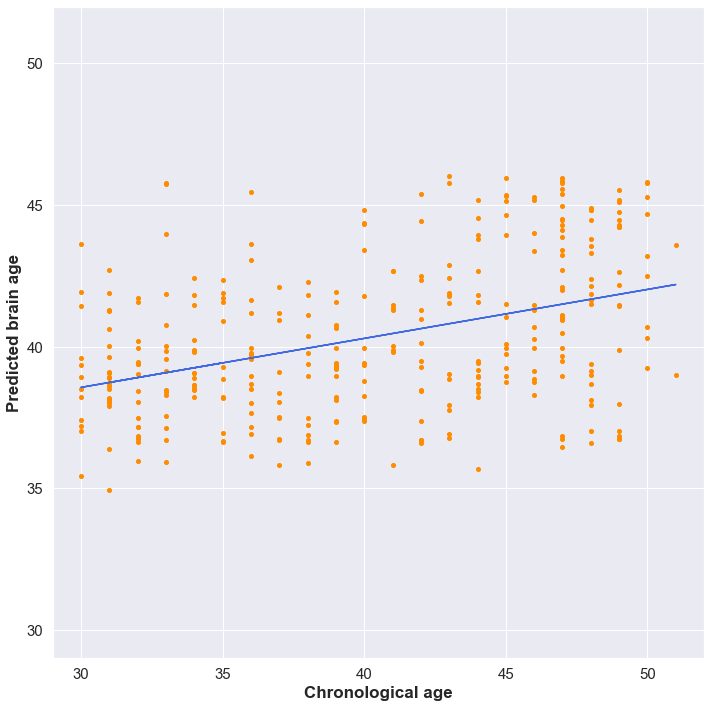

In [44]:
#PLOT RESULTS - seaborn aesthetics

sns.set()

fig, ax = plt.subplots(figsize=(10,10))


age_observed = np.concatenate((age_train, age_test))
age_predicted_overall = np.concatenate((age_predicted_cv2, age_predicted_test2))

#calculate line of best fit
slope, line_intercept, r_value, p_value, std_err = linregress(age_observed, age_predicted_overall)
line = slope*age_observed + line_intercept


ax.scatter(age_observed, age_predicted_overall, color='darkorange', s=16)
ax.plot(age_observed, line, color='royalblue')
#x0,x1 = ax.get_xlim()
#y0,y1 = ax.get_ylim()

ax.set_xlabel(r'Chronological age', size=17, weight = 'bold')
ax.set_ylabel(r'Predicted brain age', size=17, weight = 'bold')
#fig.suptitle('Correlation between observed and predicted intima media thickness (IMT)')
ax.set_xlim((29,52))
ax.set_ylim((29,52))
#ax.set_xticks(np.arange(0.4,0.9,0.08))
#ax.set_yticks(np.arange(0.4,0.9,0.08))
ax.set_aspect('equal')

ax.tick_params(axis='x', labelsize = 15)
ax.tick_params(axis='y', labelsize = 15)
plt.tight_layout()
plt.savefig("/Users/amy/Desktop/coax/brain_age_110321.png", dpi=600)

In [29]:
print("r:", r_value)
print("p:", p_value)

r: 0.39911815865084177
p: 8.079117521220689e-14


### OLD

In [ ]:
#calculates BIC (Bayesian Information Criterion)
    
    residuals = y - y_hat
    rss = np.sum(residuals**2)
    #print("rss:", rss, ", n:", n, ", k:", k)
    bic = (n * log(rss/n)) + (k * log(n)) #gaussian special case formula

In [31]:
def calculate_aic(y, y_predicted, k):
    
    rss = np.sum(np.square(y - y_predicted))
    aic = (2*k) - 2*log(rss)
    
    return aic

In [137]:
#LINEAR REGRESSION --WRONG--
# "brain score" = y_predicted2

#null model
intercept = np.ones(shape=(n_subj, 1))
lr_null = LinearRegression(fit_intercept=False)
lr_null.fit(intercept, y) 
y_pred_null = lr_null.predict(intercept)
k_null = 0 
aic_null = calculate_aic(y, y_pred_null, k_null)
bic_null = calculate_bic(y, y_pred_null, n_subj, k_null)


#brain score model
brain_score = y_predicted2.reshape(-1,1)
lr_brain = LinearRegression()
lr_brain.fit(brain_score, y) 
y_pred_brain = lr_brain.predict(brain_score)
k_brain = 1 
aic_brain = calculate_aic(y, y_pred_brain, k_brain)
bic_brain = calculate_bic(y, y_pred_brain, n_subj, k_brain)


#FI model
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
cov_data_imputed = imputer.fit_transform(cov_data)

lr_FI = LinearRegression()
lr_FI.fit(cov_data_imputed, y) 
y_pred_FI = lr_FI.predict(cov_data_imputed)
k_FI = 1 
aic_FI = calculate_aic(y, y_pred_FI, k_FI)
bic_FI = calculate_bic(y, y_pred_FI, n_subj, k_FI)


#combined model
combined_X = np.concatenate((brain_score, cov_data_imputed), axis=1)
lr_comb = LinearRegression()
lr_comb.fit(combined_X, y) 
y_pred_comb = lr_comb.predict(combined_X)
k_comb = 2 
aic_comb = calculate_aic(y, y_pred_comb, k_comb)
bic_comb = calculate_bic(y, y_pred_comb, n_subj, k_comb)


#print
print("null model aic:", aic_null)
print("brain model aic:", aic_brain)
print("FI model aic:", aic_FI)
print("combined model aic:", aic_comb)

print("")

print("null model bic:", bic_null)
print("brain model bic:", bic_brain)
print("FI model bic:", bic_FI)
print("combined model bic:", bic_comb)

rss: 2.2767323709852434 , n: 324 , k: 0
rss: 0.20630490393612702 , n: 324 , k: 1
rss: 1.937980439072367 , n: 324 , k: 1
rss: 0.20455026897447842 , n: 324 , k: 2
null model aic: -1.6454824887490775
brain model aic: 5.156800176580172
FI model aic: 0.6767071598805512
combined model aic: 7.173883039300953

null model bic: -1606.3927359393642
brain model bic: -2378.58178420691
FI model bic: -1652.8067155015715
combined model bic: -2375.568464451884


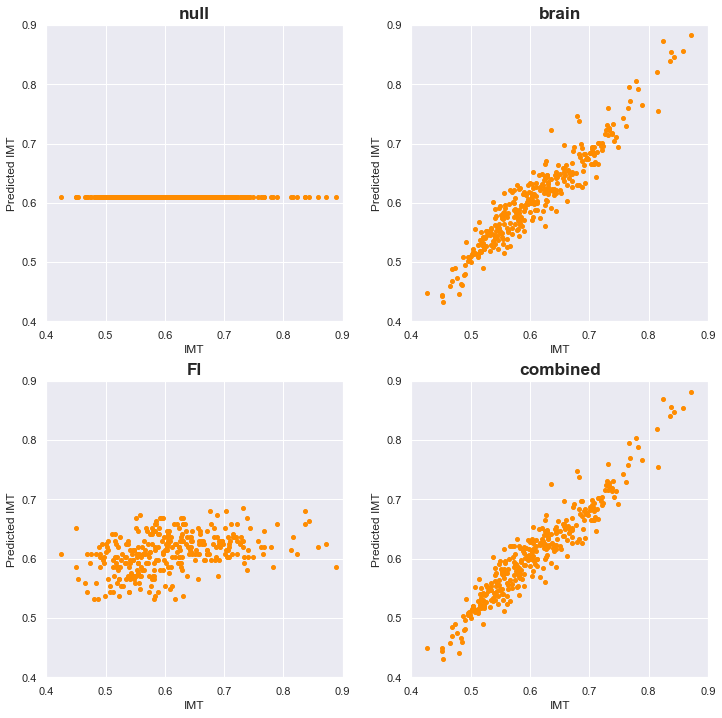

In [140]:
fig1, axes1 = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
y_hats = [y_pred_null, y_pred_brain, y_pred_FI, y_pred_comb]
fig_titles = ['null', 'brain', 'FI', 'combined']
for i, ax in enumerate(fig1.axes):

    ax.scatter(y, y_hats[i], color='darkorange', s=16)
    ax.set_title(fig_titles[i], fontsize='x-large', fontweight='bold')
    ax.set_xlabel('IMT')
    ax.set_ylabel('Predicted IMT')
    ax.set_xlim((0.4,0.9))
    ax.set_ylim((0.4,0.9))
    #ax.set_xticks(np.arange(0.4,0.9,0.08))
    #ax.set_yticks(np.arange(0.4,0.9,0.08))
    ax.set_aspect('equal')

In [96]:
#compare models to null aic
delta_brain_aic = aic_brain - aic_null
delta_FI_aic = aic_FI - aic_null
delta_comb_aic = aic_comb - aic_null

#compare full/comb model to FI aic
delta_FI_comb_aic = aic_comb - aic_FI



In [97]:
#compare models to null bic
delta_brain_bic = bic_brain - bic_null
delta_FI_bic = bic_FI - bic_null
delta_comb_bic = bic_comb - bic_null

#compare full/comb model to FI bic
delta_FI_comb_bic = bic_comb - bic_FI


Text(0, 0.5, 'BIC')

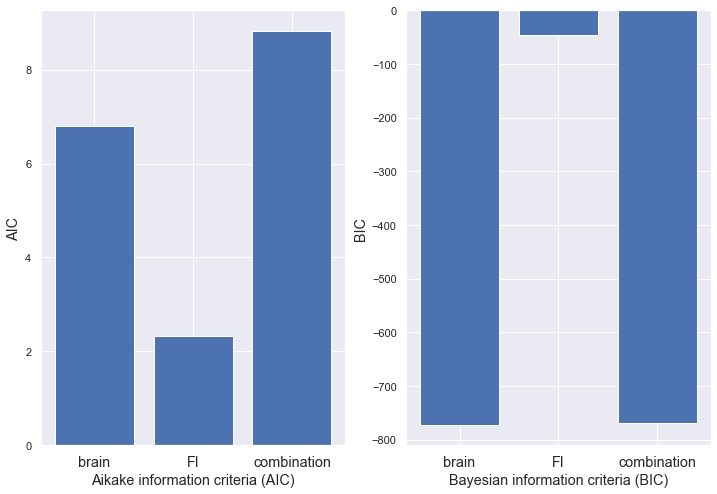

In [125]:
#plots

aic_data = [delta_brain_aic, delta_FI_aic, delta_comb_aic]
bic_data = [delta_brain_bic, delta_FI_bic, delta_comb_bic]

ic_labels = ['brain', 'FI', 'combination']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
axes[0].bar(ic_labels, aic_data, label='AIC')
axes[1].bar(ic_labels, bic_data, label='BIC')
axes[0].set_xticklabels(ic_labels, fontsize='large')
axes[1].set_xticklabels(ic_labels, fontsize='large')
axes[0].set_xlabel("Aikake information criteria (AIC)", fontsize='large')
axes[1].set_xlabel("Bayesian information criteria (BIC)", fontsize='large')
axes[0].set_ylabel("AIC", fontsize='large')
axes[1].set_ylabel("BIC", fontsize='large')
